In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
import numpy as np
import json
from matplotlib.colors import to_hex
import matplotlib.patches as mpatches

In [2]:
# read through the results on each dataset
base_path = "results/"
datasets = ["cHL_2_MIBI", "IMMUcan"]
#datasets = ["cHL_2_MIBI"]
results = []
for dataset in datasets:
    df = pd.read_csv(f"{base_path}{dataset}/final_results.csv", sep=";")
    df["dataset"] = dataset
    results.append(df)

results = pd.concat(results, ignore_index=True)

# rename celllensLITE to CellLens_LITE
#results["method"] = results["method"].str.replace("celllens_LITE", "CellLENS_Lite")
results["method"] = results["method"].str.replace("celllens_full", "CellLENS_Full")
results["method"] = results["method"].str.replace("FuseSOM_12", "FuseSOM")
results["method"] = results["method"].str.replace("FuseSOM_15", "FuseSOM")

results

method    level  f1_weighted_mean  \
0                           CellLENS_Lite  level_1          0.856754   
1                           CellLENS_Lite  level_2          0.729420   
2                           CellLENS_Lite  level_3          0.532263   
3                                 FuseSOM  level_1          0.837625   
4                                 FuseSOM  level_2          0.712334   
..                                    ...      ...               ...   
187                                tribus  level_2          0.689865   
188                                tribus  level_3          0.611721   
189  xgboost_default_StratifiedGroupKFold  level_1          0.947002   
190  xgboost_default_StratifiedGroupKFold  level_2          0.938819   
191  xgboost_default_StratifiedGroupKFold  level_3          0.925801   

     hierarchical_f1_mean  accuracy_mean  macro_f1_mean  g_mean_mean  \
0                     NaN       0.871814       0.444080     0.733353   
1                     NaN       0.742222       0.612457     0.544219   
2                0.714865       0.553599       0.508179     0.488963   
3                     NaN       0.848750       0.304318     0.635813   
4                     NaN       0.721433       0.510239     0.602267   
..                    ...            ...            ...          ...   
187                   NaN       0.683836       0.531833     0.266300   
188              0.664520       0.576541       0.385603     0.296823   
189                   NaN       0.946750       0.907800     0.912472   
190                   NaN       0.938269       0.905050     0.914320   
191              0.936042       0.924738       0.883379     0.904464   

     mcc_mean  kappa_mean   r2_mean  ...   nmi_std   jsd_std  jsd_scaled_std  \
0    0.387539    0.375349  0.990223  ...  0.028552  0.020087        0.020087   
1    0.523316    0.515819  0.976513  ...  0.014752  0.031904        0.031904   
2    0.483200    0.479692  0.889248  ...  0.012909  0.023393        0.023393   
3    0.271765    0.260078  0.980258  ...  0.000000  0.000000        0.000000   
4    0.501264    0.499749  0.987422  ...  0.000000  0.000000        0.000000   
..        ...         ...       ...  ...       ...       ...             ...   
187  0.559993    0.550454  0.796052  ...  0.061256  0.034477        0.034477   
188  0.463314    0.455693  0.865220  ...  0.041565  0.031878        0.031878   
189  0.915787    0.914977  0.991828  ...  0.012027  0.003910        0.003910   
190  0.912231    0.911607  0.995858  ...  0.010503  0.003531        0.003531   
191  0.901992    0.901470  0.999103  ...  0.006439  0.002845        0.002845   

     kl_divergence_std  kl_scaled_std  train_time_std  inference_time_std  \
0             0.578269       0.145892             NaN                 0.0   
1             0.023723       0.021639             NaN                 0.0   
2             0.033315       0.026143             NaN                 0.0   
3             0.000000       0.000000             NaN                 0.0   
4             0.000000       0.000000             NaN                 0.0   
..                 ...            ...             ...                 ...   
187           0.051491       0.041068             NaN                 0.0   
188           0.138165       0.056139             NaN                 0.0   
189           0.000678       0.000676             0.0                 0.0   
190           0.000628       0.000626             0.0                 0.0   
191           0.000597       0.000593             0.0                 0.0   

     stability  overall_score_mean     dataset  
0     0.965411            0.699593  cHL_2_MIBI  
1     0.944437            0.713176  cHL_2_MIBI  
2     0.904290            0.617164  cHL_2_MIBI  
3     1.000000            0.655228  cHL_2_MIBI  
4     1.000000            0.695431  cHL_2_MIBI  
..         ...                 ...         ...  
187   0.800445            0.657232     IMMUcan  
188   0.798031            0

In [3]:
# Get the scalability metrics

# qc train_time_mean 
# if train_time_mean is equal to inference_time_mean, set train_time_mean to 0
results["train_time_mean"] = results["train_time_mean"].fillna(0)
results["train_time_mean"] = np.where(results["train_time_mean"] == results["inference_time_mean"], 0, results["train_time_mean"]) 
results["run_time"] = results["train_time_mean"] + results["inference_time_mean"]

# scale run_time to be between 0 and 1 with a threshold
runtime_thresh = 10800
results["runtime_scaled"] = 1 - results['run_time'] / runtime_thresh
results.loc[results['runtime_scaled'] < 0, 'runtime_scaled'] = 0

In [4]:
# rename the methods to be more readable
method_rename = {
    "logistic_regression_default_StratifiedGroupKFold": "Logistic Regression",
    "most_frequent_default_StratifiedGroupKFold": "Most Frequent",
    "random_forest_default_StratifiedGroupKFold": "Random Forest",
    "stratified_default_StratifiedGroupKFold": "Stratified sampler",
    "xgboost_default_StratifiedGroupKFold": "XGBoost",
    "maps": "MAPS",
    "FuseSOM_12": "FuseSOM",
    "FuseSOM_15": "FuseSOM",
    "tribus": "Tribus",
    "scyan": "Scyan",
    "tacit": "Tacit",
    "astir": "Astir",
    "deepcelltypes": "Deepcelltypes",
    "ribca": "RIBCA",
    "flowsom": "FlowSOM"
}

results["method"] = results["method"].replace(method_rename)

# group methods by thier methodology
method_groups = {
    "Clustering_based": ["phenograph_20", "phenograph_80","leiden_res2_0", "CellLENS_Lite","CellLENS_Full",
                         "FlowSOM", "flowsom_meta_clusters", "FuseSOM_12", "FuseSOM_15", "FuseSOM"],
    "Supervised": ["XGBoost", "Logistic Regression", "Random Forest", "MAPS"],
    "Prior-knowledge based": ["Tribus", "Scyan", "Tacit", "Astir"],
    "Baselines": ["Most Frequent", "Stratified sampler"],
    "Pre-trained models": ["Deepcelltypes", "RIBCA", "nimbus_leiden_0_8", "nimbus_phenograph_cluster_k40"]  # Example, replace with actual pre-trained models
}

methods2scalability = {
    "Clustering_based" : 0.25, 
    "Supervised": 0.25,
    "Prior-knowledge based": 0.75,
    "Baselines": 1,
    "Pre-trained models": 1
}

# create scores for all methods for automation
scaling_scores = {
    "phenograph_20": 0.25,
    "phenograph_80": 0.25,
    "leiden_res2_0": 0.25,
    "CellLENS_Lite": 0.25,
    "CellLENS_Full": 0.25,
    "FlowSOM": 0.25,
    "flowsom_meta_clusters": 0.25,
    "FuseSOM_15": 0.25,
    "FuseSOM_12": 0.25,
    "FuseSOM": 0.25,
    "XGBoost": 0.25,
    "Logistic Regression": 0.25,
    "Random Forest": 0.25,
    "MAPS": 0.25,
    "Tribus": 0.6,
    "Scyan": 0.75,
    "Tacit": 0.75,
    "Astir": 0.75,
    "Most Frequent": 0,
    "Stratified sampler": 0,
    "Deepcelltypes": 1,
    "RIBCA": 1,
    "nimbus_flowsom_cluster": 0.25,
    "nimbus_leiden_0_8": 0.25

}

# apply scaling_scores to the results dataframe
results["scaling_score"] = results["method"].map(scaling_scores)
# scalability as a mean of the scaling_scores and the runtime_scaled
results["scalability"] = (results["scaling_score"] + results["runtime_scaled"]) / 2

In [ ]:
# # get a correlation matrix of the metrics
# metrics = [m for m in results.columns if m.endswith("_mean") and not m.endswith("_std")]
# metrics += ["stability", "overall_score_mean", "runtime_scaled"]
# #drop some metrics that are not needed for correlation
# metrics = [m for m in metrics if m not in ["jsd_mean", "kl_divergence_mean", "train_time_mean", "inference_time_mean"]]

# correlation_matrix = results[metrics].corr()
# plt.figure(figsize=(10, 10))
# sns.heatmap(correlation_matrix, annot=True, fmt=".1f", cmap="BrBG", square=True, cbar_kws={"shrink": .8})
# plt.title("Correlation Matrix of Metrics")
# plt.xticks(rotation=90)
# plt.yticks(rotation=0)
# plt.tight_layout()
# plt.show()

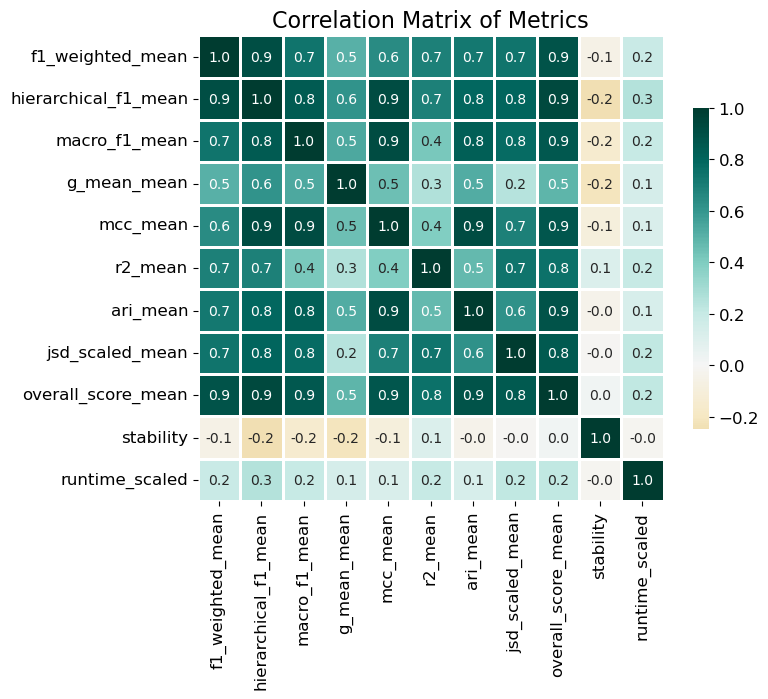

In [5]:
# pruned results to only include the relevant metrics
# get a correlation matrix of the metrics
metrics = [m for m in results.columns if m.endswith("_mean") and not m.endswith("_std")]
metrics += ["stability", "runtime_scaled"]
#drop some metrics that are not needed for correlation
metrics = [m for m in metrics if m not in ["jsd_mean", "kl_divergence_mean", "accuracy_mean", "kappa_mean", "nmi_mean", "g_mean_mean"
                                           "r2_mean", "pearson_corr_mean", "kl_scaled_mean", "jensen_scaled_mean", 
                                            "train_time_mean", "inference_time_mean"]]

correlation_matrix = results[metrics].corr()
plt.figure(figsize=(8, 8))
ax = sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".1f",
    cmap="BrBG",
    square=True,
    cbar_kws={"shrink": .5},  # removed 'center' which is not a valid argument
    annot_kws={"size": 10},
    linewidths=.75,
    center=0
)
plt.title("Correlation Matrix of Metrics", fontsize=16)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(rotation=0, fontsize=12)
# Set colorbar font size
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)
plt.tight_layout()
plt.savefig("/Users/lukashat/Documents/PhD_Schapiro/Projects/phenotype_benchmark/stage_1/correlation_matrix_metrics.svg", dpi=300)
plt.show()

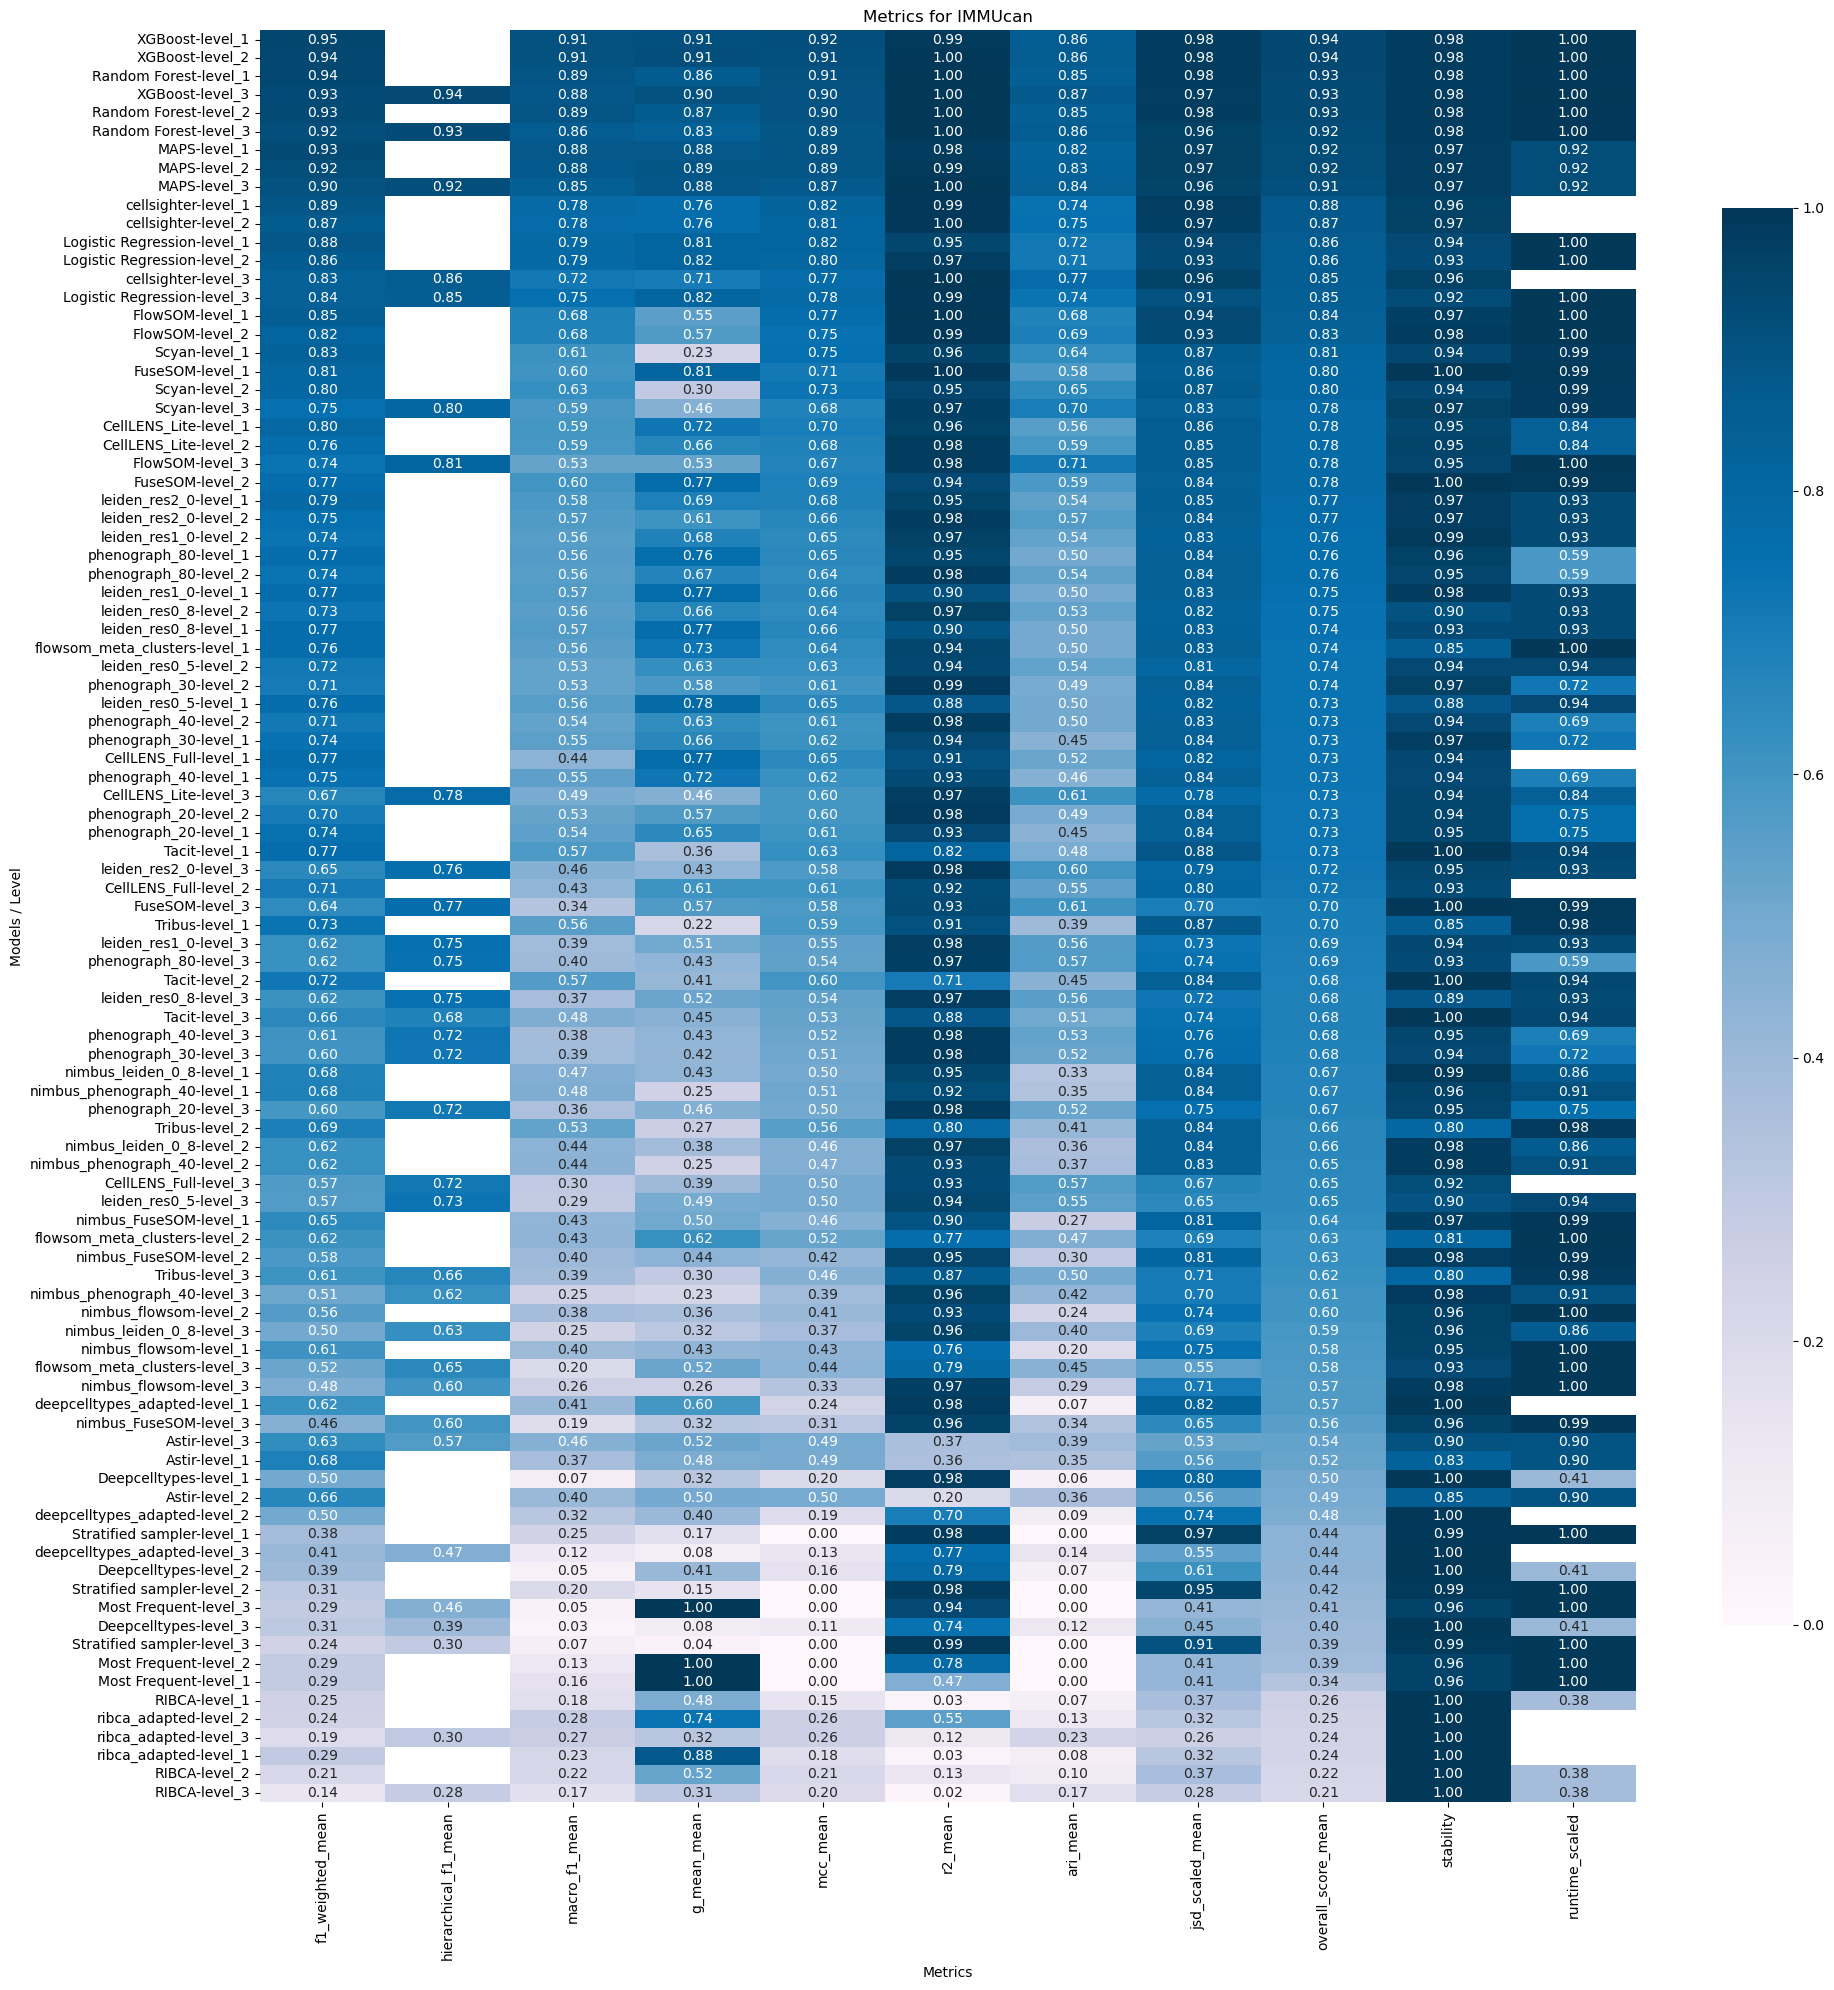

In [6]:
dataset = "IMMUcan"  # specify the dataset to visualize
#dataset = "cHL_2_MIBI"  # specify the dataset to visualize

df = results[results["dataset"] == dataset].set_index(["method", "level"])
df = df[metrics]
#df = df.sort_values(["overall_score", "method", "level"], ascending=[False, True, True])
df = df.sort_values(["overall_score_mean"], ascending=[False])

plt.figure(figsize=(20, 20))
sns.heatmap(df, annot=True, fmt=".2f", cmap="PuBu", cbar_kws={"shrink": .8})
plt.title(f"Metrics for {dataset}")
plt.xlabel("Metrics")
plt.ylabel("Models / Level")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

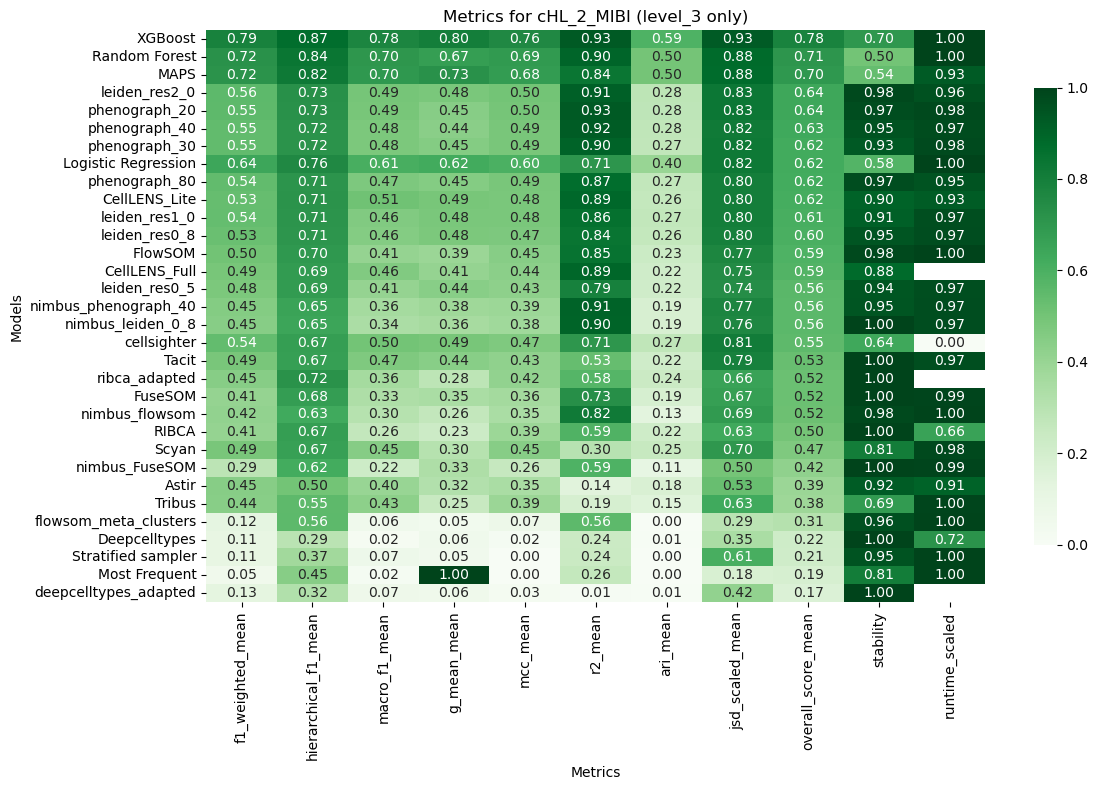

In [7]:
dataset = "IMMUcan"  # specify the dataset to visualize
dataset = "cHL_2_MIBI"  # specify the dataset to visualize

df = results[(results["dataset"] == dataset) & (results["level"] == "level_3")].set_index("method")
df = df[metrics]
df = df.sort_values(["overall_score_mean"], ascending=[False])

plt.figure(figsize=(12, 8))
sns.heatmap(df, annot=True, fmt=".2f", cmap="Greens", cbar_kws={"shrink": .8})
plt.title(f"Metrics for {dataset} (level_3 only)")
plt.xlabel("Metrics")
plt.ylabel("Models")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [8]:
# check rows where method is 'pehnograph_' or 'leiden_' and 
phenograph_rows = results[results["method"].str.startswith("phenograph_")]
leiden_rows = results[results["method"].str.startswith("leiden_")]
nimbus_rows = results[results["method"].str.startswith("nimbus_")]

# take the row with the highest value for overall score
phenograph_best = phenograph_rows.loc[phenograph_rows["overall_score_mean"].idxmax()]
leiden_best = leiden_rows.loc[leiden_rows["overall_score_mean"].idxmax()]
nimbus_best = nimbus_rows.loc[nimbus_rows["overall_score_mean"].idxmax()]

#take the name of the best phenograph and leiden methods
phenograph_best_name = phenograph_best["method"]
leiden_best_name = leiden_best["method"]
nimbus_best_name = nimbus_best["method"]

# keep only the best phenograph and leiden methods in the phenograph_rows and leiden_rows
phenograph_rows = phenograph_rows[phenograph_rows["method"] == phenograph_best_name]
leiden_rows = leiden_rows[leiden_rows["method"] == leiden_best_name]
nimbus_rows = nimbus_rows[nimbus_rows["method"] == nimbus_best_name]

#from results remove phenograph and leiden rows and add the best rows
results = results[~results["method"].str.startswith("phenograph_")]
results = results[~results["method"].str.startswith("leiden_")]
results = results[~results["method"].str.startswith("nimbus_")]
results = pd.concat([results, phenograph_rows, leiden_rows, nimbus_rows], ignore_index=True)

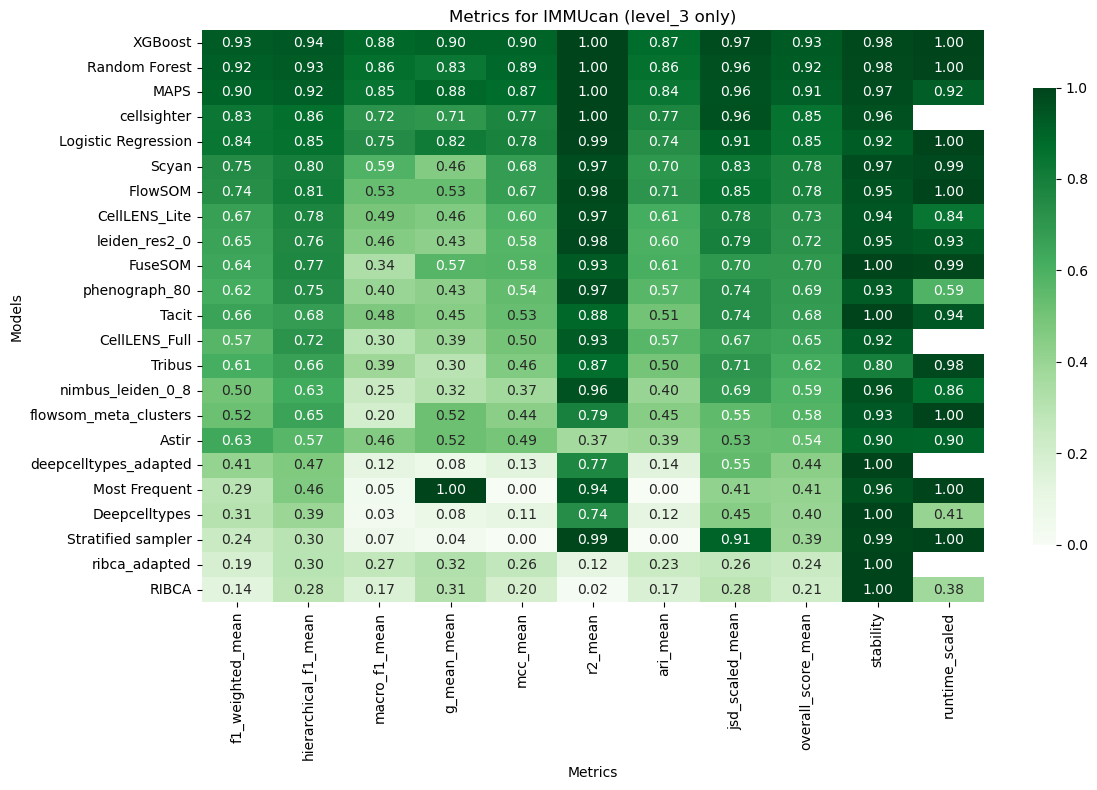

In [9]:
dataset = "IMMUcan"  # specify the dataset to visualize
#dataset = "cHL_2_MIBI"  # specify the dataset to visualize

df = results[(results["dataset"] == dataset) & (results["level"] == "level_3")].set_index("method")
df = df[metrics]
df = df.sort_values(["overall_score_mean"], ascending=[False])

plt.figure(figsize=(12, 8))
sns.heatmap(df, annot=True, fmt=".2f", cmap="Greens", cbar_kws={"shrink": .8})
plt.title(f"Metrics for {dataset} (level_3 only)")
plt.xlabel("Metrics")
plt.ylabel("Models")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [ ]:
# ## re-calculate weighted overall score

# # Metric categories and their sub-metrics with weights
# metrics_wt = {
#     "Classification Performance": {
#         "f1_weighted_mean": 0.09,
#         "hierarcheal_f1_mean": 0.15,
#         "macro_f1_mean": 0.15,
#         "mcc_mean": 0.15,
#         "g_mean_mean": 0.06
#     },
#     "Cell Type Composition": {
#         "r2_mean": 0.04,
#         "ari_mean": 0.08,
#         "jsd_scaled_mean": 0.08
#     },
#     "Stability": {
#         "stability": 0.1
#     },
#     "Scalability": {
#         "scalability": 0.1
#     }
# }

# # calculate the weighted score for each method, only if the metric is present in final_results
# def calculate_weighted_score(row, metrics_wt):
#     score = 0
#     for category, metrics in metrics_wt.items():
#         for metric, weight in metrics.items():
#             if metric in row:
#                 score += row[metric] * weight
#     return score

# # Apply the weighted score calculation
# results['weighted_score'] = results.apply(lambda row: calculate_weighted_score(row, metrics_wt), axis=1)

In [10]:
# take mean of performance metrics
results['weighted_score'] = (results["f1_weighted_mean"] + results["hierarchical_f1_mean"] +
                             results["macro_f1_mean"] + results["mcc_mean"] + results["ari_mean"] +
                             results["jsd_scaled_mean"]) / 6


In [11]:
# select some metrics for the results table
metrics2 = [
    "method", "dataset", "level", 
    "f1_weighted_mean", "hierarchical_f1_mean", "macro_f1_mean", "mcc_mean", "ari_mean", "jsd_scaled_mean", "weighted_score",
    "stability", "scalability"
]

results2 = results[metrics2].copy()

results2.to_csv("results_table.csv", index=False, sep=";")

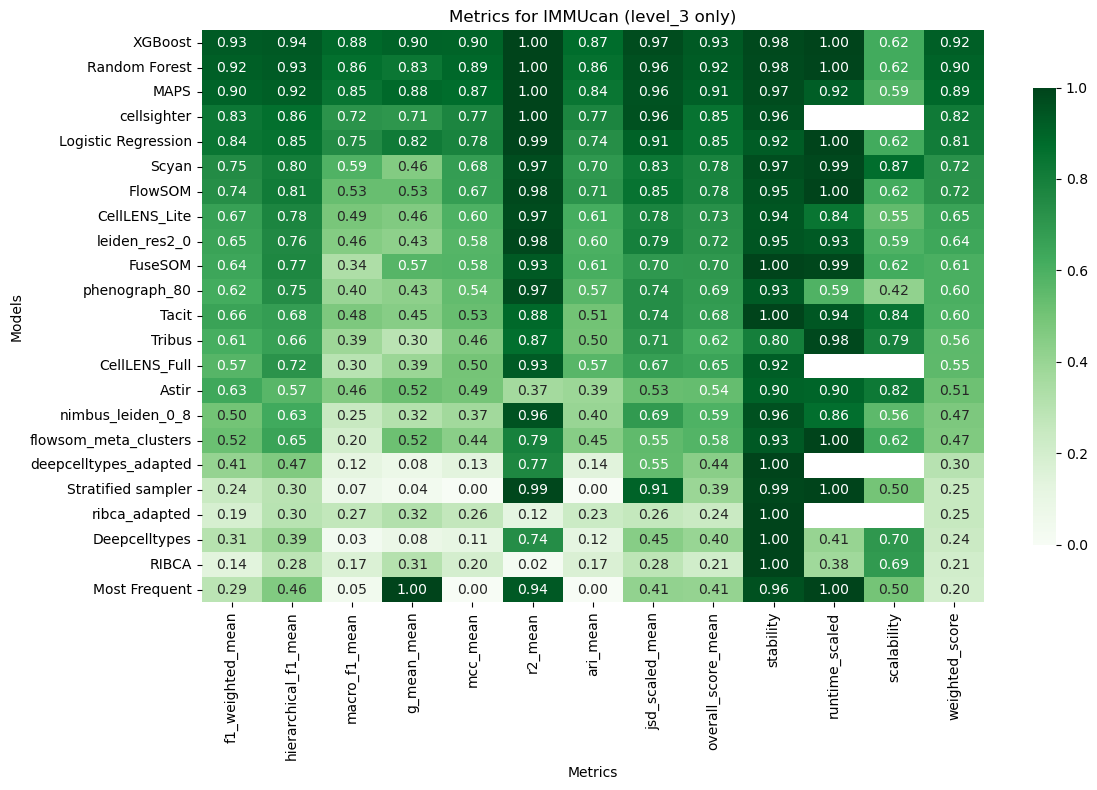

In [12]:
# Only add "scalability" and "weighted_score" if not already in metrics
for m in ["scalability", "weighted_score"]:
    if m not in metrics:
        metrics.append(m)

# Ensure metrics list is unique and preserves order
metrics = list(dict.fromkeys(metrics))

df = results[(results["dataset"] == dataset) & (results["level"] == "level_3")].set_index("method")
df = df[metrics]
# Sort by weighted_score descending, then by method name to ensure consistent order even if weighted_score is not unique
if "weighted_score" in df.columns:
    df = df.sort_values(["weighted_score", "method"], ascending=[False, True])
else:
    df = df.sort_index()

plt.figure(figsize=(12, 8))
sns.heatmap(df, annot=True, fmt=".2f", cmap="Greens", cbar_kws={"shrink": .8})
plt.title(f"Metrics for {dataset} (level_3 only)")
plt.xlabel("Metrics")
plt.ylabel("Models")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

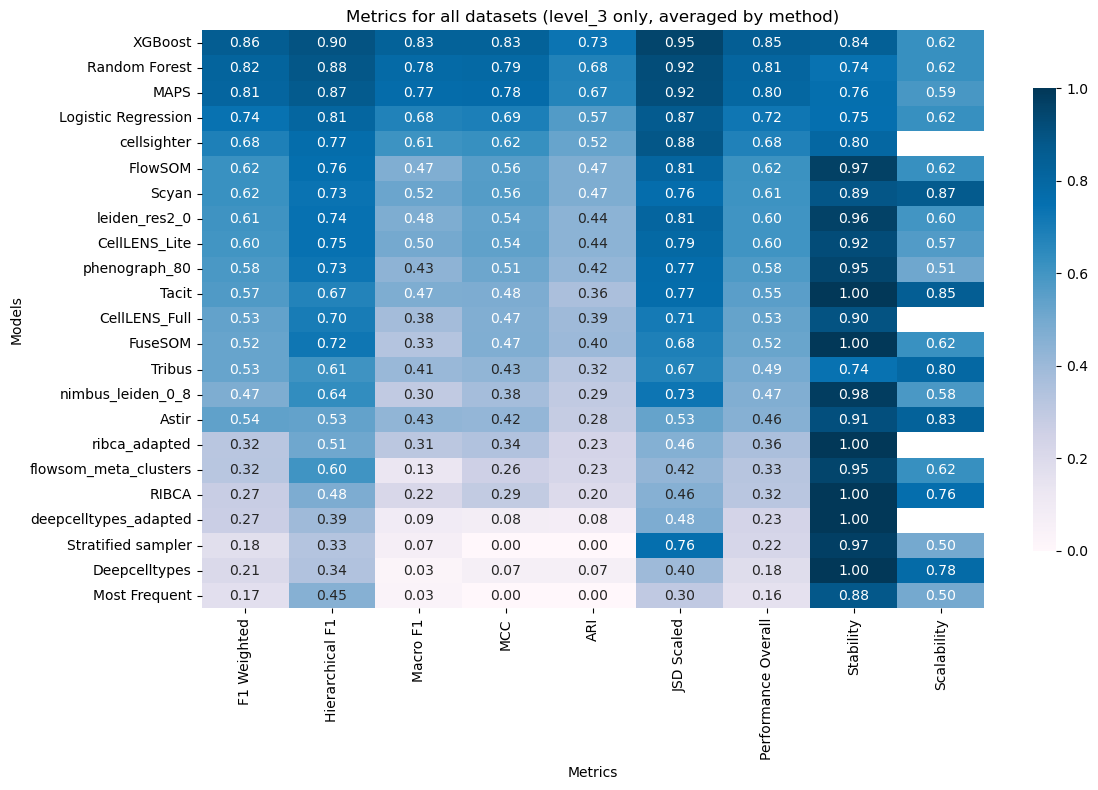

In [13]:
metrics = [m for m in results.columns if m.endswith("_mean") and not m.endswith("_std")]
metrics += ["stability", "scalability", "weighted_score"]
#drop some metrics that are not needed for correlation
metrics = [m for m in metrics if m not in ["jsd_mean", "kl_divergence_mean", "accuracy_mean", "kappa_mean", 
                                           "nmi_mean", "g_mean_mean","r2_mean",
                                            "pearson_corr_mean", "kl_scaled_mean", "jensen_scaled_mean",
                                            "train_time_mean", "inference_time_mean", "overall_score_mean"]]


# take mean of the metrics for each method for all datasets
df = results[results["level"] == "level_3"].groupby("method")[metrics].mean()

# Sort by weighted_score descending, then by method name to ensure consistent order even if weighted_score is not unique
df = df.sort_values(["weighted_score"], ascending=[False])

# rename the columns to be more readable
df = df.rename(columns={
    "f1_weighted_mean": "F1 Weighted",
    "hierarchical_f1_mean": "Hierarchical F1",
    "macro_f1_mean": "Macro F1",
    "mcc_mean": "MCC",
    "ari_mean": "ARI",
    "jsd_scaled_mean": "JSD Scaled",
    "stability": "Stability",
    "scalability": "Scalability",
    "weighted_score": "Performance Overall"
})

# move the "Performance Overall" to before "Stability" and "Scalability"
df = df[["F1 Weighted", "Hierarchical F1", "Macro F1", "MCC", "ARI", "JSD Scaled", 
         "Performance Overall",
         "Stability", "Scalability"]]


plt.figure(figsize=(12, 8))
sns.heatmap(df, annot=True, fmt=".2f", cmap="PuBu", cbar_kws={"shrink": .8})
plt.title("Metrics for all datasets (level_3 only, averaged by method)")
plt.xlabel("Metrics")
plt.ylabel("Models")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [14]:
df.to_csv("final_results_averaged.csv", sep=";")

## minimal_results

In [ ]:
results = pd.read_csv("../results/cHL_2_MIBI/minimal_results.csv", sep=";")
# pruned results to only include the relevant metrics
# get a correlation matrix of the metrics
metrics = [m for m in results.columns if m.endswith("_mean") and not m.endswith("_std")]
metrics += ["stability"]
#drop some metrics that are not needed for correlation
metrics = [m for m in metrics if m not in ["jsd_mean", "kl_divergence_mean", "accuracy_mean", "kappa_mean", "nmi_mean", "pearson_corr_mean", "kl_scaled_mean", "jensen_scaled_mean"]]

FileNotFoundError: [Errno 2] No such file or directory: '../results/cHL_2_MIBI/minimal_results.csv'

In [ ]:
# calcualte the overall score for each method
results["overall_score"] = results[metrics].mean(axis=1)
metrics.append("overall_score")
results

In [ ]:
df = results[(results["level"] == "level_3")].set_index("method")
df = df[metrics]
df = df.sort_values(["overall_score"], ascending=[False])

plt.figure(figsize=(12, 8))
sns.heatmap(df, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={"shrink": .8})
plt.title(f"Metrics for cHL2 (level_3 only)")
plt.xlabel("Metrics")
plt.ylabel("Models")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
# check rows where method is 'pehnograph_' or 'leiden_' and 
phenograph_rows = results[results["method"].str.startswith("phenograph_")]
leiden_rows = results[results["method"].str.startswith("leiden_")]

# take the row with the highest value for overall score
phenograph_best = phenograph_rows.loc[phenograph_rows["overall_score"].idxmax()]
leiden_best = leiden_rows.loc[leiden_rows["overall_score"].idxmax()]

#take the name of the best phenograph and leiden methods
phenograph_best_name = phenograph_best["method"]
leiden_best_name = leiden_best["method"]

# keep only the best phenograph and leiden methods in the phenograph_rows and leiden_rows
phenograph_rows = phenograph_rows[phenograph_rows["method"] == phenograph_best_name]
leiden_rows = leiden_rows[leiden_rows["method"] == leiden_best_name]

#from results remove phenograph and leiden rows and add the best rows
results = results[~results["method"].str.startswith("phenograph_")]
results = results[~results["method"].str.startswith("leiden_")]
results = pd.concat([results, phenograph_rows, leiden_rows], ignore_index=True)


## Heatmaps together [dump]

In [ ]:
# plot a heatmap of the results of only one dataset with metrics on the x-axis and models on the y-axis
# split by dataset
dataset1 = "IMMUcan"
dataset2 = "cHL_2_MIBI"

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(25, len(df) * 0.5), sharey=True)

cmap = 'coolwarm'

# Plot group 1
df = results[results["dataset"] == dataset1].set_index("method")
df = df[metrics]
df = df.sort_values(["overall_score", "method"], ascending=[False, True])
sns.heatmap(df, ax=axes[0], cmap=cmap, annot=True, fmt=".2f", vmin=0, vmax=1, cbar=False)
axes[0].set_title(dataset1)
axes[0].set_ylabel('Methods')
axes[0].xaxis.set_label_position('top')
axes[0].xaxis.tick_top()

# Plot group 2
df = results[results["dataset"] == dataset2].set_index("method")
df = df[metrics]
df = df.sort_values(["overall_score", "method"], ascending=[False, True])
sns.heatmap(df, cmap=cmap, annot=True, fmt=".2f", vmin=0, vmax=1, cbar=False)
axes[1].set_title(dataset2)
axes[1].set_ylabel('')  # no need to repeat y-label
axes[1].tick_params(axis='y', left=False)  # remove ticks on y-axis
axes[1].xaxis.set_label_position('top')
axes[1].xaxis.tick_top()

#plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Heatmap with overall over all levels

### If run from above, this wull use the minimal celltyper results. Make sure to otherwise use the main results


In [48]:
df3 = pd.read_csv('final_results_averaged.csv', delimiter=';')
df3

method  F1 Weighted  Hierarchical F1  Macro F1       MCC  \
0                 XGBoost     0.856627         0.902017  0.830166  0.830505   
1           Random Forest     0.818997         0.884047  0.781759  0.789616   
2                    MAPS     0.810434         0.869093  0.771846  0.777161   
3     Logistic Regression     0.740831         0.805969  0.676752  0.691181   
4             cellsighter     0.684711         0.767612  0.609490  0.622571   
5                 FlowSOM     0.621086         0.756877  0.469458  0.560184   
6                   Scyan     0.617996         0.734390  0.518945  0.562744   
7           leiden_res2_0     0.606361         0.742242  0.475343  0.538165   
8           CellLENS_Lite     0.599530         0.745103  0.497529  0.540218   
9           phenograph_80     0.582327         0.728741  0.434509  0.514301   
10                  Tacit     0.571704         0.672867  0.473088  0.477323   
11          CellLENS_Full     0.531686         0.702885  0.380603  0.467774   
12                FuseSOM     0.523746         0.723114  0.334678  0.472243   
13                 Tribus     0.527236         0.608902  0.407783  0.427326   
14      nimbus_leiden_0_8     0.474413         0.636518  0.296151  0.375246   
15                  Astir     0.540685         0.534367  0.429633  0.420975   
16          ribca_adapted     0.317574         0.510074  0.313519  0.340407   
17  flowsom_meta_clusters     0.321253         0.604064  0.129491  0.255818   
18                  RIBCA     0.273455         0.478069  0.215997  0.292096   
19  deepcelltypes_adapted     0.268449         0.393089  0.091715  0.079898   
20     Stratified sampler     0.175374         0.334975  0.068644  0.000094   
21          Deepcelltypes     0.205550         0.342222  0.025556  0.066237   
22          Most Frequent     0.171799         0.454727  0.033920  0.000000   

         ARI  JSD Scaled  Performance Overall  Stability  Scalability  
0   0.732611    0.950638             0.850427   0.841642     0.624709  
1   0.678290    0.921603             0.812385   0.741491     0.623741  
2   0.668638    0.917723             0.802482   0.755027     0.587384  
3   0.568661    0.865211             0.724767   0.751804     0.624762  
4   0.524018    0.884523             0.682154   0.799952          NaN  
5   0.473871    0.811635             0.615519   0.966357     0.623948  
6   0.474503    0.764295             0.612146   0.888289     0.867727  
7   0.440368    0.811239             0.602286   0.963828     0.598539  
8   0.437566    0.789823             0.601628   0.924021     0.567121  
9   0.418693    0.772102             0.575112   0.947690     0.509486  
10  0.363245    0.766370             0.554099   1.000000     0.851528  
11  0.391183    0.709164             0.530549   0.900091          NaN  
12  0.398663    0.684309             0.522792   1.000000     0.620548  
13  0.324058    0.669347             0.494109   0.742113     0.795140  
14  0.294411    0.726703             0.467240   0.979310     0.584094  
15  0.282387    0.529890             0.456323   0.913475     0.825802  
16  0.233670    0.459216             0.362410   1.000000          NaN  
17  0.225048    0.422314             0.326331   0.949259     0.623948  
18  0.197087    0.456642             0.318891   1.000000     0.758942  
19  0.076427    0.480251             0.231638   1.000000          NaN  
20  0.000184    0.756979             0.222708   0.971074     0.499998  
21  0.066188    0.397397             0.183858   1.000000     0.781012  
22  0.000000    0.298759             0.159867   0.882692     0.500000

In [ ]:
results = pd.read_csv('final_results_averaged.csv')

method    level  f1_weighted_mean  hierarchical_f1_mean  \
0        CellLENS_Lite  level_1          0.856754                   NaN   
1        CellLENS_Lite  level_2          0.729420                   NaN   
2        CellLENS_Lite  level_3          0.532263              0.714865   
3              FuseSOM  level_1          0.837625                   NaN   
4              FuseSOM  level_2          0.712334                   NaN   
..                 ...      ...               ...                   ...   
133  nimbus_leiden_0_8  level_2          0.678488                   NaN   
134  nimbus_leiden_0_8  level_3          0.447784              0.647863   
135  nimbus_leiden_0_8  level_1          0.676938                   NaN   
136  nimbus_leiden_0_8  level_2          0.620983                   NaN   
137  nimbus_leiden_0_8  level_3          0.501042              0.625172   

     accuracy_mean  macro_f1_mean  g_mean_mean  mcc_mean  kappa_mean  \
0         0.871814       0.444080     0.733353  0.387539    0.375349   
1         0.742222       0.612457     0.544219  0.523316    0.515819   
2         0.553599       0.508179     0.488963  0.483200    0.479692   
3         0.848750       0.304318     0.635813  0.271765    0.260078   
4         0.721433       0.510239     0.602267  0.501264    0.499749   
..             ...            ...          ...       ...         ...   
133       0.678157       0.455148     0.441230  0.429807    0.426481   
134       0.465977       0.342589     0.357905  0.375973    0.371805   
135       0.690911       0.465877     0.426743  0.497874    0.493273   
136       0.639089       0.437554     0.383395  0.464732    0.460635   
137       0.545895       0.249713     0.315191  0.374520    0.369061   

      r2_mean  ...  train_time_std  inference_time_std  stability  \
0    0.990223  ...             NaN                 0.0   0.965411   
1    0.976513  ...             NaN                 0.0   0.944437   
2    0.889248  ...             NaN                 0.0   0.904290   
3    0.980258  ...             NaN                 0.0   1.000000   
4    0.987422  ...             NaN                 0.0   1.000000   
..        ...  ...             ...                 ...        ...   
133  0.965245  ...             0.0                 0.0   1.000000   
134  0.900427  ...             0.0                 0.0   1.000000   
135  0.945714  ...             0.0                 0.0   0.988825   
136  0.965179  ...             0.0                 0.0   0.978559   
137  0.956456  ...             0.0                 0.0   0.958619   

     overall_score_mean     dataset  run_time  runtime_scaled  scaling_score  \
0              0.699593  cHL_2_MIBI   802.312        0.925712           0.25   
1              0.713176  cHL_2_MIBI   802.312        0.925712           0.25   
2              0.617164  cHL_2_MIBI   802.312        0.925712           0.25   
3              0.655228  cHL_2_MIBI    81.816        0.992424           0.25   
4              0.695431  cHL_2_MIBI    81.816        0.992424           0.25   
..                  ...         ...       ...             ...            ...   
133            0.661775  cHL_2_MIBI   302.470        0.971994           0.25   
134            0.560103  cHL_2_MIBI   302.470        0.971994           0.25   
135            0.673764     IMMUcan  1464.652        0.864384           0.25   
136            0.656620     IMMUcan  1464.652        0.864384           0.25   
137            0.592737     IMMUcan  1464.652        0.864384           0.25   

     scalability  weighted_score  
0       0.587856             NaN  
1       0.587856             NaN  
2       0.587856        0.550165  
3       0.621212             NaN  
4       0.621212             NaN  
..           ...             ...  
133     0.610997             NaN  
134     0.610997        0.460951  
135     0.557192             NaN  
136     0.557192             NaN  
137     0.557192        0.473530  

[138 rows x 44 columns]

In [17]:
# check rows where method is 'pehnograph_' or 'leiden_' and 
phenograph_rows = results[results["method"].str.startswith("phenograph_")]
leiden_rows = results[results["method"].str.startswith("leiden_")]

# take the row with the highest value for overall score
phenograph_best = phenograph_rows.loc[phenograph_rows["overall_score_mean"].idxmax()]
leiden_best = leiden_rows.loc[leiden_rows["overall_score_mean"].idxmax()]

#take the name of the best phenograph and leiden methods
phenograph_best_name = phenograph_best["method"]
leiden_best_name = leiden_best["method"]

# keep only the best phenograph and leiden methods in the phenograph_rows and leiden_rows
phenograph_rows = phenograph_rows[phenograph_rows["method"] == phenograph_best_name]
leiden_rows = leiden_rows[leiden_rows["method"] == leiden_best_name]

#from results remove phenograph and leiden rows and add the best rows
results = results[~results["method"].str.startswith("phenograph_")]
results = results[~results["method"].str.startswith("leiden_")]
results = pd.concat([results, phenograph_rows, leiden_rows], ignore_index=True)

In [18]:
# get the overall performance of each method for each level
overall_results = results[["method", "level", "overall_score_mean", "dataset"]]
overall_results


method    level  overall_score_mean     dataset
0    CellLENS_Lite  level_1            0.699593  cHL_2_MIBI
1    CellLENS_Lite  level_2            0.713176  cHL_2_MIBI
2    CellLENS_Lite  level_3            0.617164  cHL_2_MIBI
3          FuseSOM  level_1            0.655228  cHL_2_MIBI
4          FuseSOM  level_2            0.695431  cHL_2_MIBI
..             ...      ...                 ...         ...
133  leiden_res2_0  level_2            0.746443  cHL_2_MIBI
134  leiden_res2_0  level_3            0.639071  cHL_2_MIBI
135  leiden_res2_0  level_1            0.774675     IMMUcan
136  leiden_res2_0  level_2            0.769655     IMMUcan
137  leiden_res2_0  level_3            0.718751     IMMUcan

[138 rows x 4 columns]

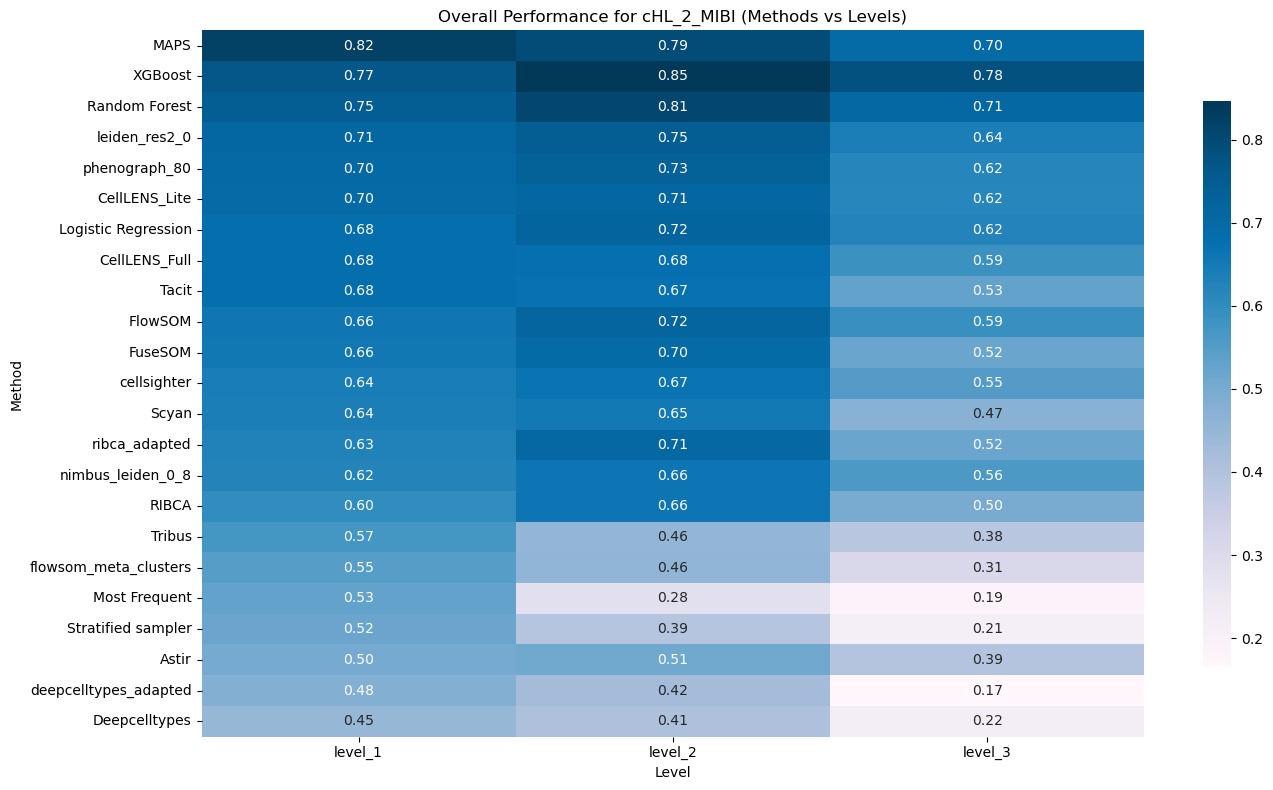

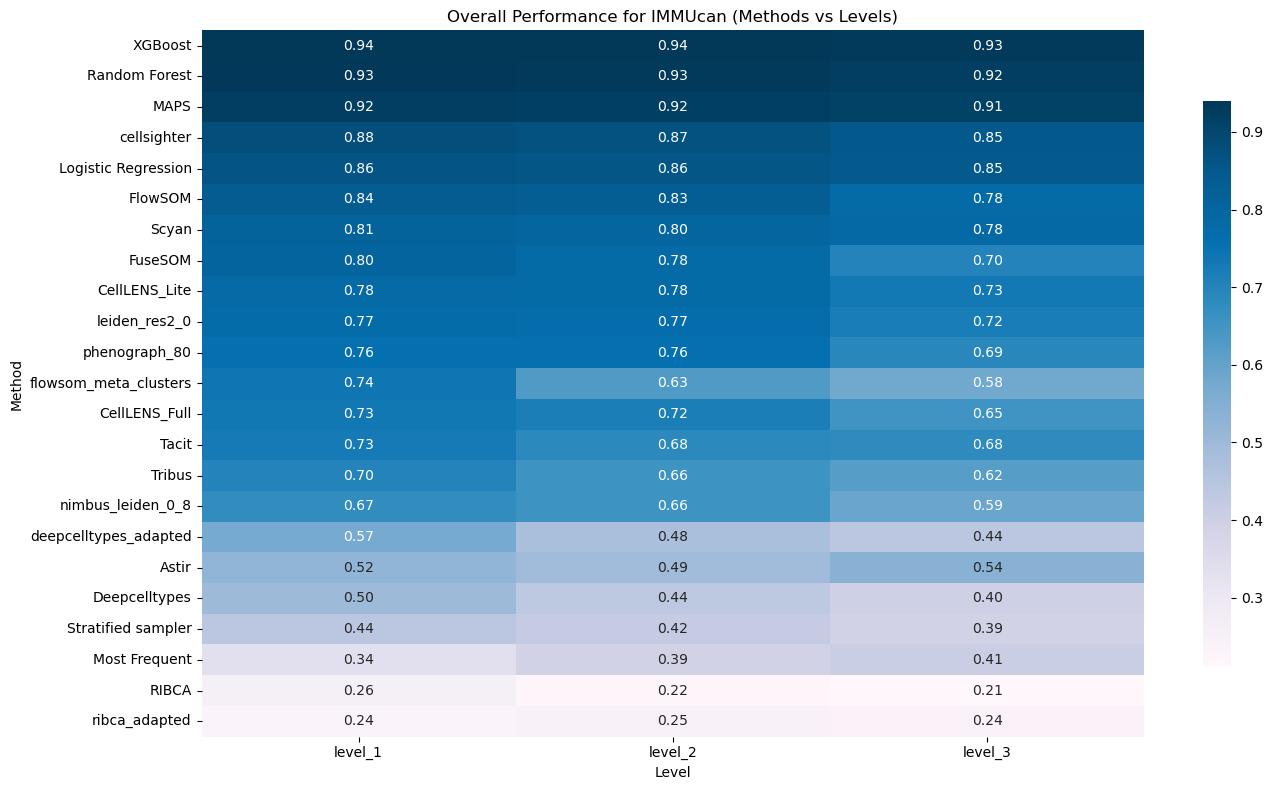

In [19]:
# for each dataset, plot a heatmap of the overall performance of each method for each level
for dataset in datasets:
    df = overall_results[overall_results["dataset"] == dataset].pivot(index="method", columns="level", values="overall_score_mean")
    df = df.sort_values(by=list(df.columns), ascending=False)
    plt.figure(figsize=(14, 8))
    # Only plot heatmap if df is not empty and has at least one column and one row
    if not df.empty and df.shape[1] > 0 and df.shape[0] > 0:
        sns.heatmap(df, annot=True, fmt=".2f", cmap="PuBu", cbar_kws={"shrink": .8})
    else:
        print(f"Warning: No data to plot for dataset '{dataset}'")
    plt.title(f"Overall Performance for {dataset} (Methods vs Levels)")
    plt.xlabel("Level")
    plt.ylabel("Method")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()


In [20]:
# pivot table for overall performance of each method for each level
overall_pivot = overall_results.pivot_table(index="method", columns=["dataset", "level"], values="overall_score_mean")
overall_pivot = overall_pivot.sort_values(by=list(overall_pivot.columns), ascending=False
)
overall_pivot

dataset                 IMMUcan                     cHL_2_MIBI            \
level                   level_1   level_2   level_3    level_1   level_2   
method                                                                     
XGBoost                0.939827  0.938033  0.932366   0.768250  0.846488   
Random Forest          0.934778  0.931461  0.922749   0.746068  0.811831   
MAPS                   0.921727  0.919903  0.911824   0.823345  0.794851   
cellsighter            0.877688  0.871437  0.850272   0.640718  0.667998   
Logistic Regression    0.862456  0.857429  0.847260   0.684438  0.724138   
FlowSOM                0.840191  0.829645  0.778982   0.659957  0.718152   
Scyan                  0.809312  0.801072  0.784375   0.638582  0.651301   
FuseSOM                0.803562  0.778476  0.702208   0.655228  0.695431   
CellLENS_Lite          0.782111  0.780483  0.729602   0.699593  0.713176   
leiden_res2_0          0.774675  0.769655  0.718751   0.708909  0.746443   
phenograph_80          0.755902  0.755729  0.690002   0.702661  0.729984   
flowsom_meta_clusters  0.737984  0.628797  0.579184   0.547110  0.458097   
CellLENS_Full          0.732870  0.716619  0.651890   0.680509  0.677911   
Tacit                  0.727119  0.684942  0.680648   0.680262  0.672070   
Tribus                 0.702199  0.657232  0.620362   0.570439  0.455622   
nimbus_leiden_0_8      0.673764  0.656620  0.592737   0.623318  0.661775   
deepcelltypes_adapted  0.571355  0.476622  0.439995   0.481028  0.424457   
Astir                  0.523444  0.494543  0.538846   0.503258  0.510446   
Deepcelltypes          0.501895  0.435250  0.398897   0.446262  0.407464   
Stratified sampler     0.441228  0.419795  0.392915   0.518126  0.389908   
Most Frequent          0.335737  0.389668  0.406557   0.528643  0.281618   
RIBCA                  0.257686  0.220725  0.211999   0.598491  0.662652   
ribca_adapted          0.236011  0.247206  0.238927   0.628400  0.706974   

dataset                          
level                   level_3  
method                           
XGBoost                0.784181  
Random Forest          0.708233  
MAPS                   0.697146  
cellsighter            0.551612  
Logistic Regression    0.623528  
FlowSOM                0.590148  
Scyan                  0.470519  
FuseSOM                0.520754  
CellLENS_Lite          0.617164  
leiden_res2_0          0.639071  
phenograph_80          0.620379  
flowsom_meta_clusters  0.310191  
CellLENS_Full          0.585207  
Tacit                  0.530316  
Tribus                 0.384008  
nimbus_leiden_0_8      0.560103  
deepcelltypes_adapted  0.166586  
Astir                  0.392579  
Deepcelltypes          0.221727  
Stratified sampler     0.214936  
Most Frequent          0.187708  
RIBCA                  0.496801  
ribca_adapted          0.521552

In [21]:
sorted_by_average = overall_pivot.loc[overall_pivot.mean(axis=1).sort_values(ascending=False).index]
sorted_by_average

dataset                 IMMUcan                     cHL_2_MIBI            \
level                   level_1   level_2   level_3    level_1   level_2   
method                                                                     
XGBoost                0.939827  0.938033  0.932366   0.768250  0.846488   
MAPS                   0.921727  0.919903  0.911824   0.823345  0.794851   
Random Forest          0.934778  0.931461  0.922749   0.746068  0.811831   
Logistic Regression    0.862456  0.857429  0.847260   0.684438  0.724138   
cellsighter            0.877688  0.871437  0.850272   0.640718  0.667998   
FlowSOM                0.840191  0.829645  0.778982   0.659957  0.718152   
leiden_res2_0          0.774675  0.769655  0.718751   0.708909  0.746443   
CellLENS_Lite          0.782111  0.780483  0.729602   0.699593  0.713176   
phenograph_80          0.755902  0.755729  0.690002   0.702661  0.729984   
FuseSOM                0.803562  0.778476  0.702208   0.655228  0.695431   
Scyan                  0.809312  0.801072  0.784375   0.638582  0.651301   
CellLENS_Full          0.732870  0.716619  0.651890   0.680509  0.677911   
Tacit                  0.727119  0.684942  0.680648   0.680262  0.672070   
nimbus_leiden_0_8      0.673764  0.656620  0.592737   0.623318  0.661775   
Tribus                 0.702199  0.657232  0.620362   0.570439  0.455622   
flowsom_meta_clusters  0.737984  0.628797  0.579184   0.547110  0.458097   
Astir                  0.523444  0.494543  0.538846   0.503258  0.510446   
ribca_adapted          0.236011  0.247206  0.238927   0.628400  0.706974   
deepcelltypes_adapted  0.571355  0.476622  0.439995   0.481028  0.424457   
RIBCA                  0.257686  0.220725  0.211999   0.598491  0.662652   
Deepcelltypes          0.501895  0.435250  0.398897   0.446262  0.407464   
Stratified sampler     0.441228  0.419795  0.392915   0.518126  0.389908   
Most Frequent          0.335737  0.389668  0.406557   0.528643  0.281618   

dataset                          
level                   level_3  
method                           
XGBoost                0.784181  
MAPS                   0.697146  
Random Forest          0.708233  
Logistic Regression    0.623528  
cellsighter            0.551612  
FlowSOM                0.590148  
leiden_res2_0          0.639071  
CellLENS_Lite          0.617164  
phenograph_80          0.620379  
FuseSOM                0.520754  
Scyan                  0.470519  
CellLENS_Full          0.585207  
Tacit                  0.530316  
nimbus_leiden_0_8      0.560103  
Tribus                 0.384008  
flowsom_meta_clusters  0.310191  
Astir                  0.392579  
ribca_adapted          0.521552  
deepcelltypes_adapted  0.166586  
RIBCA                  0.496801  
Deepcelltypes          0.221727  
Stratified sampler     0.214936  
Most Frequent          0.187708

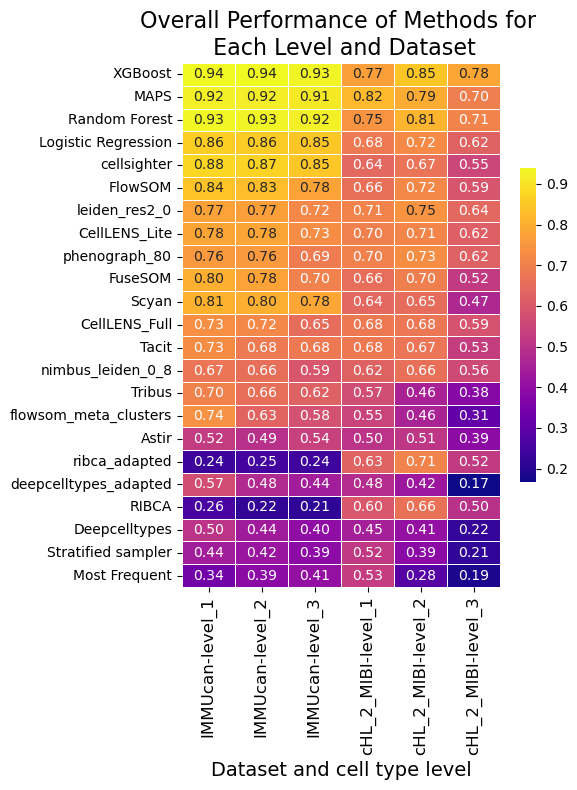

In [22]:
# plot a heatmap of the overall performance of each method for each level for each dataset sepaarated
plt.figure(figsize=(6, 8))
sns.heatmap(sorted_by_average, annot=True, fmt=".2f", cmap="plasma", cbar_kws={"shrink": .6}, annot_kws={"size": 10}, linewidths=.6)
plt.title("Overall Performance of Methods for \n Each Level and Dataset", fontsize=16)
plt.xlabel("Dataset and cell type level", fontsize=14)
plt.xticks(fontsize=12)
plt.ylabel("")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("/Users/lukashat/Documents/PhD_Schapiro/Projects/phenotype_benchmark/stage_1/overall_performance_heatmap_granularities.svg", dpi=300)
plt.show()

## Bar-plot for each method overall performance over all datasets

In [23]:
# group methods by thier methodology
method_groups = {
    "clustering_based": ["phenograph_20", "leiden_res2_0", "celllens_LITE","celllens_full","flowsom", "flowsom_meta_clusters", "cellLen"],
    "supervised": ["XGBoost", "Logistic Regression", "Random Forest", "maps"],
    "prior-knowledge based": ["tribus", "scyan", "tacit", "astir"],
    "baselines": ["Most Frequent", "Stratified sampler"],
    "pre-trained models": ["deepcelltypes", "ribca", "nimbus_flowsom_cluster", "nimbus_phenograph_cluster_k40"]  # Example, replace with actual pre-trained models
}

In [24]:
# rename the methods to be more readable
method_rename = {
    "logistic_regression_default_StratifiedGroupKFold": "Logistic Regression",
    "most_frequent_default_StratifiedGroupKFold": "Most Frequent",
    "random_forest_default_StratifiedGroupKFold": "Random Forest",
    "stratified_default_StratifiedGroupKFold": "Stratified sampler",
    "xgboost_default_StratifiedGroupKFold": "XGBoost"
}
results["method"] = results["method"].replace(method_rename)

In [25]:
overall_performance = results.groupby("method")["weighted_score"].mean().sort_values(ascending=False).reset_index()
overall_performance["method"] = overall_performance["method"].replace(method_rename)

In [26]:
# Prepare method group mapping for each method
method_to_group = {}
for group, methods in method_groups.items():
    for m in methods:
        method_to_group[m] = group

# Use readable names from method_rename
method_to_group.update({method_rename.get(k, k): v for k, v in method_to_group.items()})

# Create a DataFrame for plotting
plot_df = overall_performance.reset_index()
plot_df["group"] = plot_df["method"].map(method_to_group).fillna("Other")

# Sort by group, then by score
plot_df = plot_df.sort_values(["group", "weighted_score"], ascending=[True, False])

# # Add horizontal dotted lines for baselines
# baseline_scores = plot_df[plot_df["group"] == "baselines"]["overall_score"]
# for score in baseline_scores:
#     plt.axhline(y=score, color='gray', linestyle='--', linewidth=0.8)

    
# plt.figure(figsize=(14, 7))
# sns.barplot(x="method", y="overall_score", hue="group", data=plot_df, dodge=False, palette="gist_earth")
# plt.title("Overall Performance of Each Method Across All Datasets (Grouped)")
# plt.xlabel("Method")
# plt.ylabel("Overall Score")
# plt.xticks(rotation=45, ha='right')
# plt.legend(title="Method Group", bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()
# plt.show()

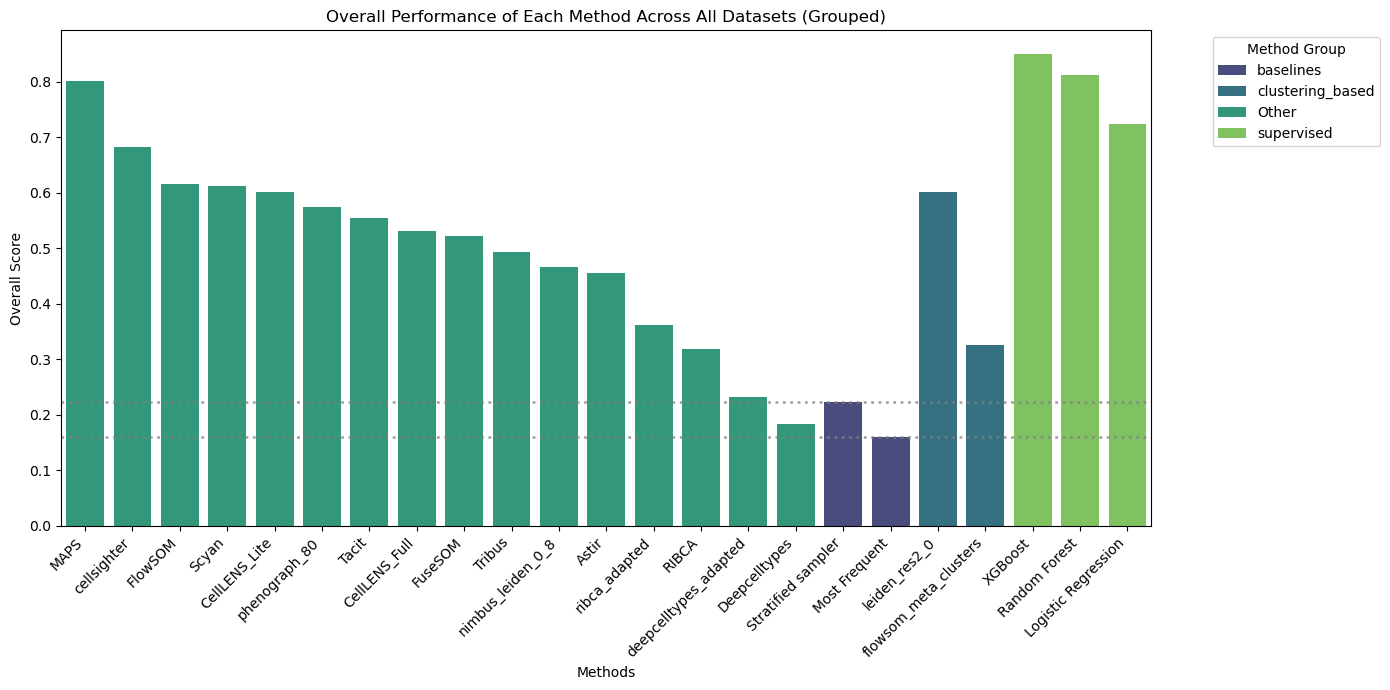

In [27]:
# Compute mean overall_score per group
group_order = plot_df.groupby("group")["weighted_score"].mean().sort_values(ascending=True).index.tolist()

plt.figure(figsize=(14, 7))
ax = sns.barplot(
    x="method",
    y="weighted_score",
    hue="group",
    data=plot_df,
    dodge=False,
    palette="viridis",
    hue_order=group_order
)

# Add horizontal dotted lines for baselines
baseline_scores = plot_df[plot_df["group"] == "baselines"]["weighted_score"]
for score in baseline_scores:
    plt.axhline(score, color="gray", linestyle=":", linewidth=2, alpha=0.7)

plt.title("Overall Performance of Each Method Across All Datasets (Grouped)")
plt.xlabel("Methods")
plt.ylabel("Overall Score")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Method Group", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## Overall scores

In [28]:
results

method    level  f1_weighted_mean  hierarchical_f1_mean  \
0    CellLENS_Lite  level_1          0.856754                   NaN   
1    CellLENS_Lite  level_2          0.729420                   NaN   
2    CellLENS_Lite  level_3          0.532263              0.714865   
3          FuseSOM  level_1          0.837625                   NaN   
4          FuseSOM  level_2          0.712334                   NaN   
..             ...      ...               ...                   ...   
133  leiden_res2_0  level_2          0.762143                   NaN   
134  leiden_res2_0  level_3          0.558350              0.726656   
135  leiden_res2_0  level_1          0.785374                   NaN   
136  leiden_res2_0  level_2          0.748594                   NaN   
137  leiden_res2_0  level_3          0.654372              0.757827   

     accuracy_mean  macro_f1_mean  g_mean_mean  mcc_mean  kappa_mean  \
0         0.871814       0.444080     0.733353  0.387539    0.375349   
1         0.742222       0.612457     0.544219  0.523316    0.515819   
2         0.553599       0.508179     0.488963  0.483200    0.479692   
3         0.848750       0.304318     0.635813  0.271765    0.260078   
4         0.721433       0.510239     0.602267  0.501264    0.499749   
..             ...            ...          ...       ...         ...   
133       0.755269       0.654016     0.667410  0.581561    0.579041   
134       0.567562       0.494196     0.480733  0.501169    0.499297   
135       0.802368       0.582428     0.685475  0.681077    0.675881   
136       0.771797       0.572252     0.613127  0.662614    0.657613   
137       0.689330       0.456489     0.426428  0.575161    0.571049   

      r2_mean  ...  train_time_std  inference_time_std  stability  \
0    0.990223  ...             NaN                 0.0   0.965411   
1    0.976513  ...             NaN                 0.0   0.944437   
2    0.889248  ...             NaN                 0.0   0.904290   
3    0.980258  ...             NaN                 0.0   1.000000   
4    0.987422  ...             NaN                 0.0   1.000000   
..        ...  ...             ...                 ...        ...   
133  0.985918  ...             0.0                 0.0   0.982311   
134  0.912862  ...             0.0                 0.0   0.981489   
135  0.954735  ...             0.0                 0.0   0.972968   
136  0.981580  ...             0.0                 0.0   0.973736   
137  0.984544  ...             0.0                 0.0   0.946166   

     overall_score_mean     dataset  run_time  runtime_scaled  scaling_score  \
0              0.699593  cHL_2_MIBI   802.312        0.925712           0.25   
1              0.713176  cHL_2_MIBI   802.312        0.925712           0.25   
2              0.617164  cHL_2_MIBI   802.312        0.925712           0.25   
3              0.655228  cHL_2_MIBI    81.816        0.992424           0.25   
4              0.695431  cHL_2_MIBI    81.816        0.992424           0.25   
..                  ...         ...       ...             ...            ...   
133            0.746443  cHL_2_MIBI   425.868        0.960568           0.25   
134            0.639071  cHL_2_MIBI   425.868        0.960568           0.25   
135            0.774675     IMMUcan   717.256        0.933587           0.25   
136            0.769655     IMMUcan   717.256        0.933587           0.25   
137            0.718751     IMMUcan   717.256        0.933587           0.25   

     scalability  weighted_score  
0       0.587856             NaN  
1       0.587856             NaN  
2       0.587856        0.550165  
3       0.621212             NaN  
4       0.621212             NaN  
..           ...             ...  
133     0.605284             NaN  
134     0.605284        0.565085  
135     0.591794             NaN  
136     0.591794             NaN  
137     0.591794        0.639488  

[138 rows x 44 columns]

In [29]:
#take rows where level is level_3
results_lvl3 = results[results["level"] == "level_3"]
# pivot dataset and overall score
results2 = results_lvl3.pivot(index=["method"], columns="dataset", values=["weighted_score"])
# keep only the dataset name as the column name
results2.columns = results2.columns.droplevel(0)

results2['avg_score'] = results2.mean(axis=1)
#results2['rank'] = results2['avg_score'].rank(ascending=False, method='min')
results2

dataset                 IMMUcan  cHL_2_MIBI  avg_score
method                                                
Astir                  0.511870    0.400776   0.456323
CellLENS_Full          0.554334    0.506764   0.530549
CellLENS_Lite          0.653091    0.550165   0.601628
Deepcelltypes          0.235304    0.132413   0.183858
FlowSOM                0.719940    0.511097   0.615519
FuseSOM                0.605021    0.440563   0.522792
Logistic Regression    0.810906    0.638628   0.724767
MAPS                   0.889596    0.715369   0.802482
Most Frequent          0.201980    0.117754   0.159867
RIBCA                  0.207406    0.430376   0.318891
Random Forest          0.902379    0.722392   0.812385
Scyan                  0.723296    0.500995   0.612146
Stratified sampler     0.252703    0.192713   0.222708
Tacit                  0.597502    0.510696   0.554099
Tribus                 0.555435    0.432783   0.494109
XGBoost                0.915736    0.785118   0.850427
cellsighter            0.818695    0.545613   0.682154
deepcelltypes_adapted  0.302176    0.161100   0.231638
flowsom_meta_clusters  0.468576    0.184086   0.326331
leiden_res2_0          0.639488    0.565085   0.602286
nimbus_leiden_0_8      0.473530    0.460951   0.467240
phenograph_80          0.602013    0.548211   0.575112
ribca_adapted          0.251105    0.473715   0.362410

In [30]:
# Step 1: Compute ranks (lower rank = better performance)
rank_df = results2.rank(ascending=False, axis=0)
# order by the avg_score   
rank_df = rank_df.sort_values(by='avg_score', ascending=True)
rank_df = rank_df[['cHL_2_MIBI', 'IMMUcan', 'avg_score']]

In [ ]:
rank_df

In [31]:
from matplotlib.patches import PathPatch
from matplotlib.path import Path

def draw_curve(ax, x1, y1, x2, y2, color, linewidth=12, alpha=1):
    verts = [
        (x1, y1),                # Start point
        ((x1 + x2) / 2, y1),     # Control point 1
        ((x1 + x2) / 2, y2),     # Control point 2
        (x2, y2)                 # End point
    ]
    codes = [Path.MOVETO, Path.CURVE4, Path.CURVE4, Path.CURVE4]
    path = Path(verts, codes)
    patch = PathPatch(path, facecolor='none', edgecolor=color, lw=linewidth, alpha=alpha)
    ax.add_patch(patch)

/var/folders/ry/jl4ll0zx1l709rh4r7_0cq6r0000gn/T/ipykernel_55777/736122282.py:51: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend().remove()


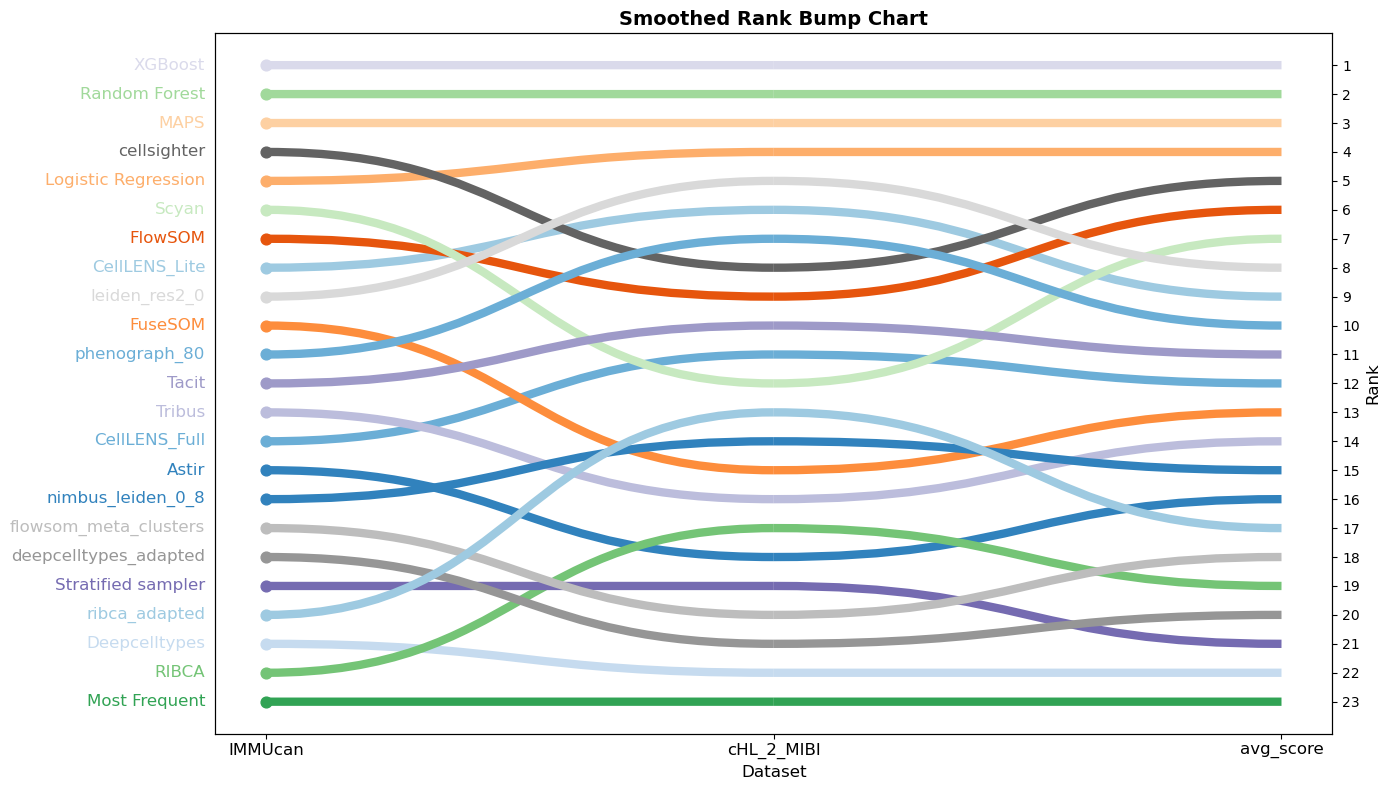

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Rank the data
rank_df = results2.rank(ascending=True, axis=0)
datasets = rank_df.columns
methods = rank_df.index

# Sort methods by mean rank
rank_df = rank_df.loc[rank_df.mean(axis=1).sort_values().index]

# Set colors
palette = sns.color_palette("tab20c", n_colors=len(methods))
method_colors = dict(zip(methods, palette))

# Create plot
fig, ax = plt.subplots(figsize=(14, 8))

x_vals = np.arange(len(datasets))

for method in methods:
    y = rank_df.loc[method].values
    color = method_colors[method]

    # Draw smooth curves between each dataset
    for i in range(len(x_vals) - 1):
        draw_curve(ax, x_vals[i], y[i], x_vals[i+1], y[i+1], color=color, linewidth=6)

    # Start and end dots
    ax.scatter(x_vals[0], y[0], color=color, s=60, zorder=2)
    ax.text(x_vals[0] - 0.12, y[0], method, ha='right', va='center', color=color, fontsize=12)

# Right y-axis: rank labels
ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())
ax2.set_yticks(range(1, len(rank_df) + 1))
ax2.set_yticklabels(range(1, len(rank_df) + 1))
ax2.set_ylabel("Rank", fontsize=12)
ax2.invert_yaxis()

# Style
ax.set_yticks([])
ax.set_ylabel("")
ax.tick_params(axis='y', left=False)
ax.set_xticks(x_vals)
ax.set_xticklabels(datasets, rotation=0, ha='center', fontsize=12)
ax.set_xlabel("Dataset", fontsize=12)
ax.set_title("Smoothed Rank Bump Chart", fontsize=14, weight='bold')
ax.grid(axis='y', linestyle='--', alpha=0.3)
ax.legend().remove()
plt.tight_layout()
plt.show()

In [33]:
with open('/Users/lukashat/Documents/PhD_Schapiro/Projects/phenotype_benchmark/github/pheno_benchmark_small/src/plotting/method_colors.json', 'r') as f:
    method_colors = json.load(f)


In [34]:
method_colors

{'Supervised': [0.9677975592919913, 0.44127456009157356, 0.5358103155058701],
 'Unsupervised': [0.6804189127793346, 0.6151497514677574, 0.19405452111445337],
 'Prior-Knowledge-driven': [0.20125317221201128,
  0.6907920815379025,
  0.47966761189275336],
 'Pre-trained Models': [0.2197995660828324,
  0.6625157876850336,
  0.7732093159317209],
 'Baselines': [0.8004936186423958, 0.47703363533737203, 0.9579547196007522]}

In [35]:
# group methods by thier methodology
method_groups = {
    "Unsupervised": ["phenograph_20", "phenograph_80","leiden_res2_0", "CellLENS_Lite","CellLENS_Full",
                         "FlowSOM", "flowsom_meta_clusters", "FuseSOM", "FuseSOM_15"],
    "Supervised": ["XGBoost", "Logistic Regression", "Random Forest", "MAPS"],
    "Prior-Knowledge-driven": ["Tribus", "Scyan", "Tacit", "Astir"],
    "Baselines": ["Most Frequent", "Stratified sampler"],
    "Pre-trained Models": ["Deepcelltypes", "RIBCA", "nimbus_leiden_0_8"]  # Example, replace with actual pre-trained models
}

In [37]:
print(rank_df)

dataset                IMMUcan  cHL_2_MIBI  avg_score
method                                               
Most Frequent              1.0         1.0        1.0
Deepcelltypes              3.0         2.0        2.0
deepcelltypes_adapted      6.0         3.0        4.0
Stratified sampler         5.0         5.0        3.0
RIBCA                      2.0         7.0        5.0
flowsom_meta_clusters      7.0         4.0        6.0
ribca_adapted              4.0        11.0        7.0
Astir                      9.0         6.0        8.0
nimbus_leiden_0_8          8.0        10.0        9.0
Tribus                    11.0         8.0       10.0
FuseSOM                   14.0         9.0       11.0
CellLENS_Full             10.0        13.0       12.0
Tacit                     12.0        14.0       13.0
phenograph_80             13.0        17.0       14.0
Scyan                     18.0        12.0       17.0
CellLENS_Lite             16.0        18.0       15.0
FlowSOM                   17

/var/folders/ry/jl4ll0zx1l709rh4r7_0cq6r0000gn/T/ipykernel_55777/3607645279.py:70: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend().remove()


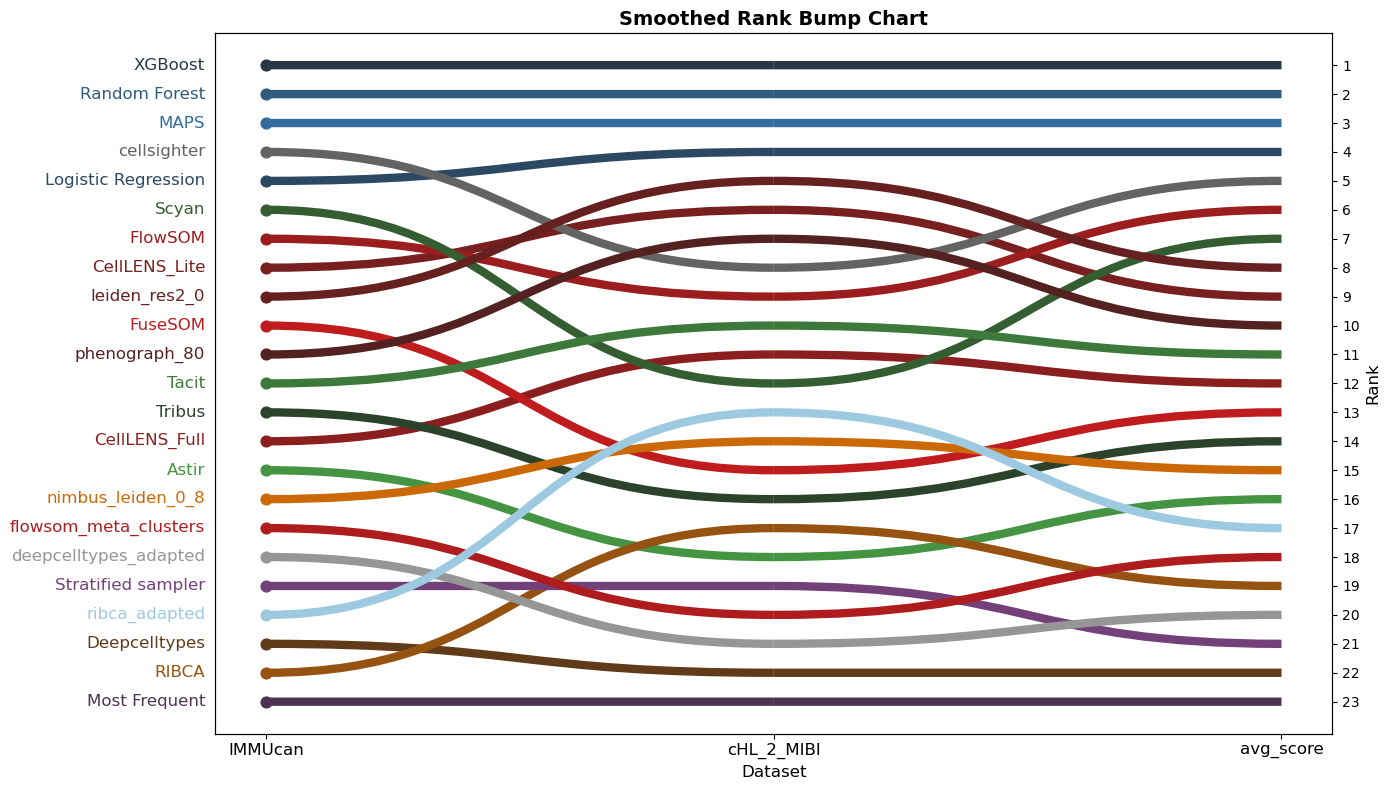

In [ ]:
rank_df = results2.rank(ascending=True, axis=0)
datasets = rank_df.columns
methods = rank_df.index

# Sort methods by mean rank
rank_df = rank_df.loc[rank_df.mean(axis=1).sort_values().index]

# Set colors: assign similar colors to methods in the same group

# Assign a base color for each group using a palette
group_palette = sns.color_palette("Set1", n_colors=len(method_groups))
group_names = list(method_groups.keys())
group_color_map = dict(zip(group_names, group_palette))

# Assign colors to methods based on their group
method_colors = {}
for group, methods_in_group in method_groups.items():
    base_color = group_color_map[group]
    # Slightly vary the color for each method in the group
    for i, method in enumerate(methods_in_group):
        # Use a lighter/darker shade for each method
        color = sns.dark_palette(base_color, n_colors=len(methods_in_group)+2)[i+1]
        method_colors[method] = to_hex(color)

# For methods not in any group, assign a default color
for method in methods:
    if method not in method_colors:
        method_colors[method] = to_hex(sns.color_palette("tab20c", n_colors=len(methods))[list(methods).index(method)])

# Create plot
fig, ax = plt.subplots(figsize=(14, 8))

x_vals = np.arange(len(datasets))

for method in methods:
    y = rank_df.loc[method].values
    color = method_colors[method]

    # Draw smooth curves between each dataset
    for i in range(len(x_vals) - 1):
        draw_curve(ax, x_vals[i], y[i], x_vals[i+1], y[i+1], color=color, linewidth=6)

    # Start and end dots
    ax.scatter(x_vals[0], y[0], color=color, s=60, zorder=2)
    ax.text(x_vals[0] - 0.12, y[0], method, ha='right', va='center', color=color, fontsize=12)

# Right y-axis: rank labels
ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())
ax2.set_yticks(range(1, len(rank_df) + 1))
ax2.set_yticklabels(range(1, len(rank_df) + 1))
ax2.set_ylabel("Rank", fontsize=12)
ax2.invert_yaxis()

# Style
ax.set_yticks([])
ax.set_ylabel("")
ax.tick_params(axis='y', left=False)
ax.set_xticks(x_vals)
ax.set_xticklabels(datasets, rotation=0, ha='center', fontsize=12)
ax.set_xlabel("Dataset", fontsize=12)
ax.set_title("Smoothed Rank Bump Chart", fontsize=14, weight='bold')
ax.grid(axis='y', linestyle='--', alpha=0.3)
ax.legend().remove()
plt.tight_layout()
plt.show()

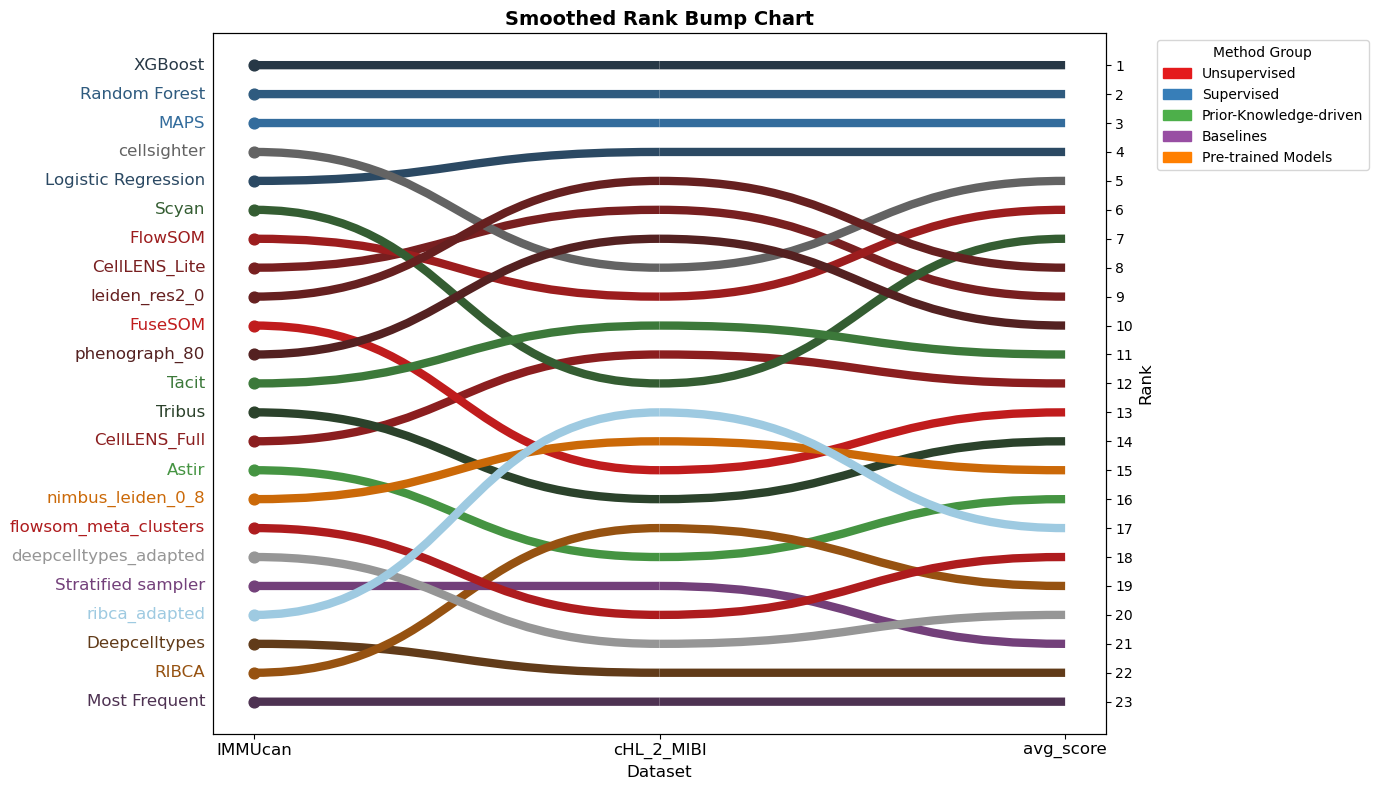

FileNotFoundError: [Errno 2] No such file or directory: '../figures/smoothed_rank_bump_chart.svg'

In [ ]:

# Create plot
fig, ax = plt.subplots(figsize=(14, 8))

x_vals = np.arange(len(datasets))

for method in methods:
    y = rank_df.loc[method].values
    color = method_colors[method]

    # Draw smooth curves between each dataset
    for i in range(len(x_vals) - 1):
        draw_curve(ax, x_vals[i], y[i], x_vals[i+1], y[i+1], color=color, linewidth=6)

    # Start and end dots
    ax.scatter(x_vals[0], y[0], color=color, s=60, zorder=2)
    ax.text(x_vals[0] - 0.12, y[0], method, ha='right', va='center', color=color, fontsize=12)

# Right y-axis: rank labels
ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())
ax2.set_yticks(range(1, len(rank_df) + 1))
ax2.set_yticklabels(range(1, len(rank_df) + 1))
ax2.set_ylabel("Rank", fontsize=12)
ax2.invert_yaxis()

# Style
ax.set_yticks([])
ax.set_ylabel("")
ax.tick_params(axis='y', left=False)
ax.set_xticks(x_vals)
ax.set_xticklabels(datasets, rotation=0, ha='center', fontsize=12)
ax.set_xlabel("Dataset", fontsize=12)
ax.set_title("Smoothed Rank Bump Chart", fontsize=14, weight='bold')
ax.grid(axis='y', linestyle='--', alpha=0.3)

# Add legend for method groups
legend_handles = []
for group, color in group_color_map.items():
    legend_handles.append(mpatches.Patch(color=to_hex(color), label=group))
ax.legend(handles=legend_handles, title="Method Group", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# save as svg
#fig.savefig("../figures/smoothed_rank_bump_chart.svg", format='svg', bbox_inches='tight')


KeyError: 'deepcelltypes_adapted'

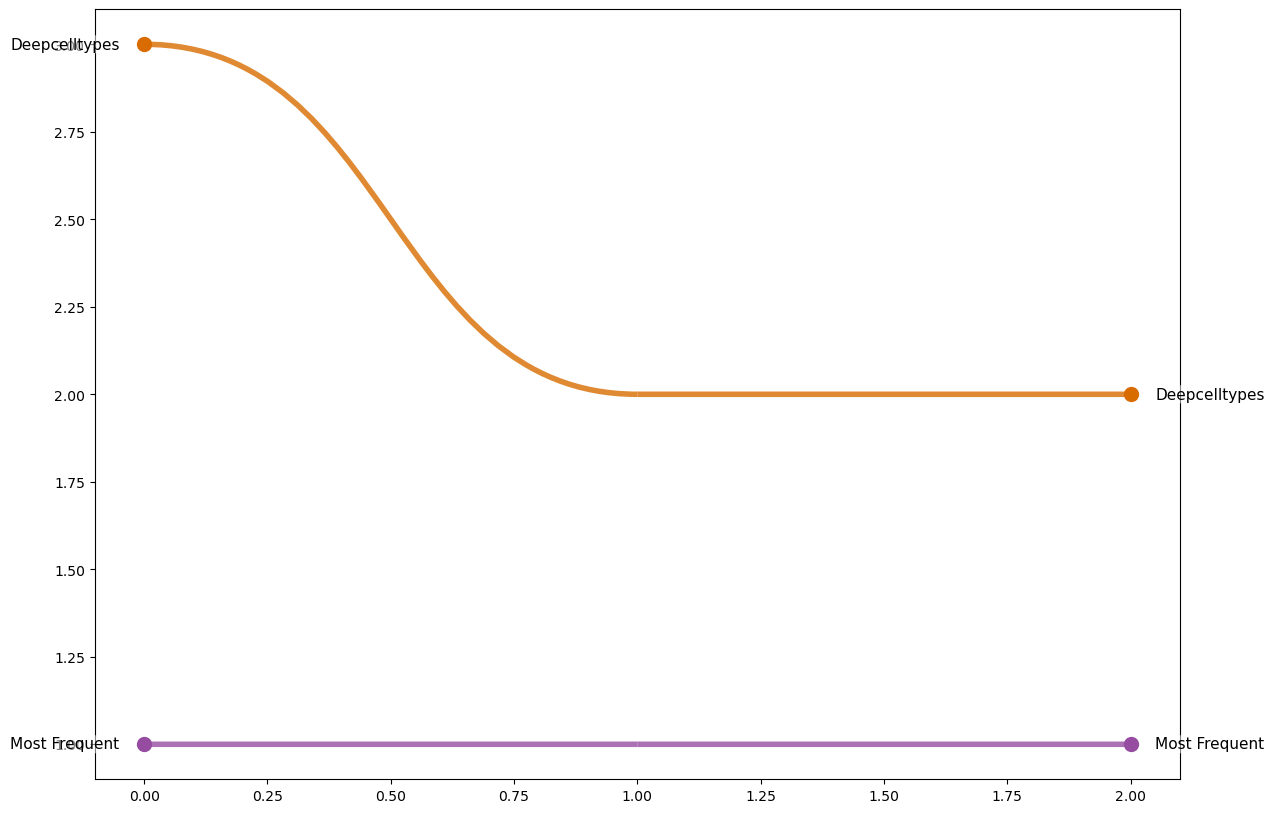

In [45]:
import colorsys
import matplotlib.path as mpath

final_method_colors = {}
for group, methods_in_group in method_groups.items():
    base_color_rgb = group_color_map[group]
    
    # Convert base RGB to HLS (Hue, Lightness, Saturation) for easier manipulation
    base_color_hls = colorsys.rgb_to_hls(*base_color_rgb)
    
    # Generate a range of lightness values for the methods in this group
    # We create n+2 points and take the inner n to avoid pure white/black
    n_methods = len(methods_in_group)
    lightness_vals = np.linspace(0.3, 0.8, num=n_methods + 2)[1:-1]
    
    # Sort methods to ensure consistent color assignment
    sorted_methods = sorted(methods_in_group)
    
    for i, method_name in enumerate(sorted_methods):
        # Create the new HLS color by replacing the lightness
        new_hls_color = (base_color_hls[0], lightness_vals[i], base_color_hls[2])
        
        # Convert back to RGB and assign to the method
        final_method_colors[method_name] = colorsys.hls_to_rgb(*new_hls_color)

# --- 3. Plotting ---

# Helper function to draw smooth curves (Bezier curve)
def draw_curve(ax, x1, y1, x2, y2, **kwargs):
    """Draws a smooth Bezier curve between two points."""
    path_data = [
        (mpath.Path.MOVETO, (x1, y1)),
        (mpath.Path.CURVE4, (x1 + 0.5, y1)), # Control point 1
        (mpath.Path.CURVE4, (x2 - 0.5, y2)), # Control point 2
        (mpath.Path.CURVE4, (x2, y2)),      # Endpoint
    ]
    codes, verts = zip(*path_data)
    path = mpath.Path(verts, codes)
    patch = mpatches.PathPatch(path, facecolor='none', edgecolor=kwargs.pop('color'), **kwargs)
    ax.add_patch(patch)

# Create plot
fig, ax = plt.subplots(figsize=(14, 10))

datasets = rank_df.columns
methods = rank_df.index
x_vals = np.arange(len(datasets))

for method in methods:
    y = rank_df.loc[method].values
    
    # *** KEY CHANGE HERE ***
    # Use the newly generated specific color for each method
    color = final_method_colors[method]

    # Draw smooth curves between each dataset
    for i in range(len(x_vals) - 1):
        draw_curve(ax, x_vals[i], y[i], x_vals[i+1], y[i+1], color=color, linewidth=4, alpha=0.8)

    # Start and end dots and labels
    ax.scatter(x_vals[0], y[0], color=color, s=100, zorder=5)
    ax.text(x_vals[0] - 0.05, y[0], method, ha='right', va='center', color='black', fontsize=11,
            bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.1'))
            
    ax.scatter(x_vals[-1], y[-1], color=color, s=100, zorder=5)
    ax.text(x_vals[-1] + 0.05, y[-1], method, ha='left', va='center', color='black', fontsize=11,
            bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.1'))

# Invert y-axis so Rank 1 is at the top
ax.invert_yaxis()
ax.set_ylim(len(methods) + 1, 0.5)

# Style
ax.set_yticks(range(1, len(methods) + 1))
ax.set_ylabel("Rank", fontsize=12)
ax.set_xticks(x_vals)
ax.set_xticklabels(datasets, rotation=0, ha='center', fontsize=12)
ax.set_xlabel("Dataset", fontsize=12)
ax.set_title("Smoothed Rank Bump Chart by Method Group", fontsize=16, weight='bold', pad=20)
ax.grid(axis='y', linestyle='--', alpha=0.5)

# Remove spines
for spine in ['top', 'right', 'left', 'bottom']:
    ax.spines[spine].set_visible(False)
    
ax.tick_params(axis='both', which='both', length=0)

# Add legend for method groups using the BASE colors
legend_handles = []
for group, color in group_color_map.items():
    legend_handles.append(mpatches.Patch(color=to_hex(color), label=group))

ax.legend(handles=legend_handles, title="Method Groups", bbox_to_anchor=(0.5, -0.15), 
          loc='upper center', ncol=len(group_color_map), fontsize=11, title_fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust layout to make space for legend
plt.show()


## Hierarcheal F1 score

In [ ]:
# get the hierarchy mappings from the qt files
qt_path = "../data/all_qt"
#read all csv files in the qt_path
qt_files = [f for f in os.listdir(qt_path) if f.endswith('.csv')]
hierarchy_mappings = {}

for qt_file in qt_files:
    qt_df = pd.read_csv(os.path.join(qt_path, qt_file))
    # Create a hierarchical mapping from cell_type to level_2 and level_1 for this file
    mapping = qt_df.drop_duplicates(subset=['cell_type', 'level_2_cell_type', 'level_1_cell_type'])[
        ['cell_type', 'level_2_cell_type', 'level_1_cell_type']
    ].set_index('cell_type').to_dict(orient='index')
    # Update the global mapping without including the qt file name
    hierarchy_mappings.update(mapping)

# Remove duplicate cell types in the hierarchy_mappings (if any)
unique_cell_types = set()
for cell_type in list(hierarchy_mappings.keys()):
    if cell_type not in unique_cell_types:
        unique_cell_types.add(cell_type)
    else:
        del hierarchy_mappings[cell_type]

#save the hierarchy mappings to a file
with open('hierarchy_mappings.pkl', 'wb') as f:
    import pickle
    pickle.dump(hierarchy_mappings, f)



In [ ]:
#read the hierarchy mappings from the file
with open('hierarchy_mappings.pkl', 'rb') as f:
    import pickle
    hierarchy_mappings = pickle.load(f)

In [ ]:
import json
from collections import defaultdict
from typing import Dict

# Build a nested dictionary tree from the flat mapping
def build_tree(mapping: Dict[str, Dict[str, str]]) -> Dict:
    tree = defaultdict(lambda: defaultdict(list))
    for leaf, levels in mapping.items():
        level1 = levels['level_1_cell_type']
        level2 = levels['level_2_cell_type']
        tree[level1][level2].append(leaf)
    return tree

# Convert tree to indented text view
def tree_to_text(tree: Dict, indent: int = 0) -> str:
    lines = []
    for level1, sublevels in tree.items():
        lines.append('  ' * indent + level1)
        for level2, leaves in sublevels.items():
            lines.append('  ' * (indent + 1) + level2)
            for leaf in leaves:
                lines.append('  ' * (indent + 2) + leaf)
    return '\n'.join(lines)

# Create the tree and save it to a txt file
tree = build_tree(hierarchy_mappings)
tree_text = tree_to_text(tree)

# Save to a text file
file_path = "cell_type_hierarchy.txt"
with open(file_path, "w") as f:
    f.write(tree_text)



In [ ]:
def parse_tree_file(file_path: str) -> dict:
    """Parses a 2-space-indented tree file and returns label -> ancestor path mapping."""
    with open(file_path, 'r') as f:
        lines = f.readlines()

    label_to_ancestors = {}
    path_stack = []

    for line in lines:
        stripped = line.lstrip()
        indent = len(line) - len(stripped)
        level = indent // 2  # Assumes 2 spaces per indent

        path_stack = path_stack[:level]
        path_stack.append(stripped.strip())

        if level >= 2:
            label = path_stack[-1]
            label_to_ancestors[label] = path_stack[:-1]  # from root to parent

    return label_to_ancestors


def hierarchical_f1_score(y_true, y_pred, ancestor_map):
    """Computes hierarchical F1 given ground truths, predictions, and an ancestor map."""
    scores = []

    for true_label, pred_label in zip(y_true, y_pred):
        true_anc = set(ancestor_map.get(true_label, []))
        pred_anc = set(ancestor_map.get(pred_label, []))

        if not true_anc or not pred_anc:
            scores.append(0.0)
            continue

        intersection = true_anc & pred_anc
        precision = len(intersection) / len(pred_anc)
        recall = len(intersection) / len(true_anc)
        f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) else 0.0
        scores.append(f1)

    return sum(scores) / len(scores)

In [ ]:
file_path = "cell_type_hierarchy.txt"
ancestor_map = parse_tree_file(file_path)

df = pd.read_csv("../results/IMMUcan/scyan/level3/predictions_4.csv")
df


In [ ]:

# Example predictions
y_true = df["true_phenotype"]
y_pred = df["predicted_phenotype"]

score = hierarchical_f1_score(y_true, y_pred, ancestor_map)
print(f"Hierarchical F1 Score: {score:.4f}")

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print("\n Classification Report:\n")
print(classification_report(y_true, y_pred, zero_division=0))

print(" Hierarchical F1 Score:", round(hierarchical_f1_score(y_true, y_pred, ancestor_map), 4))

In [ ]:
from collections import defaultdict

def hierarchical_classification_report(y_true, y_pred, ancestor_map):
    """
    Returns a dict similar to classification_report, but using hierarchical precision/recall/F1.
    """
    per_class = defaultdict(lambda: {"precision": [], "recall": [], "f1": [], "support": 0})

    for t, p in zip(y_true, y_pred):
        t_anc = set(ancestor_map.get(t, []))
        p_anc = set(ancestor_map.get(p, []))

        inter = t_anc & p_anc
        prec = len(inter) / len(p_anc) if p_anc else 0.0
        rec = len(inter) / len(t_anc) if t_anc else 0.0
        f1 = (2 * prec * rec / (prec + rec)) if (prec + rec) else 0.0

        per_class[t]["precision"].append(prec)
        per_class[t]["recall"].append(rec)
        per_class[t]["f1"].append(f1)
        per_class[t]["support"] += 1

    # Format results like sklearn
    results = {}
    precisions, recalls, f1s, supports = [], [], [], []

    for label, stats in per_class.items():
        precision = np.mean(stats["precision"])
        recall = np.mean(stats["recall"])
        f1_score = np.mean(stats["f1"])
        support = stats["support"]

        results[label] = {
            "hier_precision": round(precision, 4),
            "hier_recall": round(recall, 4),
            "hier_f1": round(f1_score, 4),
            "support": support
        }

        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1_score)
        supports.append(support)

    # Add macro avg
    results["macro avg"] = {
        "hier_precision": round(np.mean(precisions), 4),
        "hier_recall": round(np.mean(recalls), 4),
        "hier_f1": round(np.mean(f1s), 4),
        "support": sum(supports)
    }

    # Add weighted avg
    weighted_precision = sum(p * s for p, s in zip(precisions, supports)) / sum(supports)
    weighted_recall = sum(r * s for r, s in zip(recalls, supports)) / sum(supports)
    weighted_f1 = sum(f * s for f, s in zip(f1s, supports)) / sum(supports)
    results["weighted avg"] = {
        "hier_precision": round(weighted_precision, 4),
        "hier_recall": round(weighted_recall, 4),
        "hier_f1": round(weighted_f1, 4),   
        "support": sum(supports)

    }

    return results

In [ ]:
report = hierarchical_classification_report(y_true, y_pred, ancestor_map)

# Print in classification_report format
print(f"{'Label':<20} {'Prec':>7} {'Rec':>7} {'F1':>7} {'Support':>8}")
for label, scores in report.items():
    print(f"{label:<20} {scores['hier_precision']:>7.3f} {scores['hier_recall']:>7.3f} {scores['hier_f1']:>7.3f} {scores['support']:>8}")


## Plots for data distribution

In [ ]:
import plotly.graph_objects as go

def parse_tree_levels(file_path):
    # Parse the indented tree file and return a list of (parent, child) pairs for all levels
    with open(file_path, 'r') as f:
        lines = f.readlines()

    pairs = []
    stack = []
    for line in lines:
        stripped = line.lstrip()
        indent = len(line) - len(stripped)
        level = indent // 2
        stack = stack[:level]
        stack.append(stripped.strip())
        if level > 0:
            pairs.append((stack[-2], stack[-1]))
    return pairs

def generate_sankey_from_tree(file_path):
    pairs = parse_tree_levels(file_path)
    labels = sorted(set([p for pair in pairs for p in pair]))
    label_to_idx = {label: i for i, label in enumerate(labels)}
    source = [label_to_idx[parent] for parent, child in pairs]
    target = [label_to_idx[child] for parent, child in pairs]
    value = [1] * len(pairs)

    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=labels,
        ),
        link=dict(
            source=source,
            target=target,
            value=value,
        )
    )])
    fig.update_layout(title_text="Cell Type Hierarchy Sankey Diagram (All Levels)", font_size=10)
    fig.update_layout(width=1200, height=1000)
    fig.show()

generate_sankey_from_tree(file_path)


In [ ]:
import plotly.express as px
import plotly.graph_objects as go

file_path = "cell_type_hierarchy.txt"

def parse_tree_for_sunburst(file_path):
    # Parse the indented tree file and return names and parents for sunburst
    names = []
    parents = []
    stack = []
    with open(file_path, 'r') as f:
        for line in f:
            stripped = line.lstrip()
            indent = len(line) - len(stripped)
            level = indent // 2
            name = stripped.strip()
            if not name:
                continue
            if level == 0:
                parent = ""
            else:
                parent = stack[level - 1]
            if name not in names:  # avoid duplicates
                names.append(name)
                parents.append(parent)
            if len(stack) <= level:
                stack.append(name)
            else:
                stack[level] = name

    return names, parents

def generate_radial_tree(file_path):
    names, parents = parse_tree_for_sunburst(file_path)
    fig = px.sunburst(
        names=names,
        parents=parents,
        #width=1000,
        #height=800,
        maxdepth=3,
        insidetextorientation='radial'
    )

    fig.update_layout(
        margin=dict(t=10, l=10, r=10, b=10)
    )

    fig.show()
    fig.write_html("../website/plotly_figures/sunburst_distribution.html")

generate_radial_tree(file_path)

In [ ]:
import plotly.express as px

def parse_tree_for_sunburst(file_path):
    # Parse the indented tree file and return names and parents for sunburst
    names = []
    parents = []
    stack = []
    with open(file_path, 'r') as f:
        for line in f:
            stripped = line.lstrip()
            indent = len(line) - len(stripped)
            level = indent // 2
            name = stripped.strip()
            if not name:
                continue
            if level == 0:
                parent = ""
            else:
                parent = stack[level - 1]
            if name not in names:  # avoid duplicates
                names.append(name)
                parents.append(parent)
            if len(stack) <= level:
                stack.append(name)
            else:
                stack[level] = name

    return names, parents

def generate_radial_tree(file_path):
    names, parents = parse_tree_for_sunburst(file_path)
    fig = px.sunburst(
        names=names,
        parents=parents,
        width=1000,
        height=800,
        maxdepth=4,
    )

    fig.update_layout(
                        margin=dict(t=10, l=10, r=10, b=10)
                     )

    fig.show()
    #print(fig.to_html())

generate_radial_tree(file_path)

In [ ]:
import plotly.express as px

def parse_tree_for_sunburst(file_path):
    # Parse the indented tree file and return names and parents for sunburst
    names = []
    parents = []
    stack = []
    with open(file_path, 'r') as f:
        for line in f:
            stripped = line.lstrip()
            indent = len(line) - len(stripped)
            level = indent // 2
            name = stripped.strip()
            if not name:
                continue
            if level == 0:
                parent = ""
            else:
                parent = stack[level - 1]
            if name not in names:  # avoid duplicates
                names.append(name)
                parents.append(parent)
            if len(stack) <= level:
                stack.append(name)
            else:
                stack[level] = name

    return names, parents

def generate_radial_tree(file_path):
    names, parents = parse_tree_for_sunburst(file_path)
    fig = px.sunburst(
        names=names,
        parents=parents,
        width=1000,
        height=800,
        maxdepth=3,
        color_discrete_sequence=px.colors.qualitative.T10
    )

    fig.update_layout(
                        margin=dict(t=10, l=10, r=10, b=10)
                     )

    fig.show()

    #save as svg
    fig.write_image("../figures/sunburst_3.svg")
    #print(fig.to_html())

generate_radial_tree(file_path)

## stacked performance bar-plot 

In [ ]:
results_lvl3

In [ ]:
#rename id col to method
results_lvl3 = results_lvl3.rename(columns={"id": "method"})

In [ ]:
# get methods and results[metrics] in a dataframe
results_cat = results_lvl3.set_index('method')
results_cat = results_cat[metrics]
# take mean of each metric by method
results_cat = results_cat.groupby(results_cat.index).mean()
results_cat

In [ ]:
df = results_cat

# Check column count
n_metrics = len(df.columns)

# Choose a colormap with enough colors
from matplotlib.cm import get_cmap
cmap = get_cmap("Set2", n_metrics)  # will generate n_metrics colors
colors = [cmap(i) for i in range(n_metrics)]

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
left = [0] * len(df)

# Plot each metric as a segment
for i, col in enumerate(df.columns):
    ax.barh(df.index, df[col], left=left, label=col, color=colors[i])
    left = [l + v for l, v in zip(left, df[col])]

# Aesthetics
ax.set_xlabel("Score")
ax.set_title("Horizontal Stacked Bar Chart by Metric")
ax.legend(title="Metric", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# Step 2: Make method → group mapping
method_to_group = {method: group for group, methods in method_groups.items() for method in methods}

# Step 3: Add group to your DataFrame
df['group'] = df.index.map(method_to_group)

# Step 4: Sort by group (and optionally by method name within group)
df_sorted = df.sort_values(by=['group', df.columns[0]])  # replace columns[0] with a metric name if needed

# Step 5: Plot horizontal stacked bar
metrics = [col for col in df_sorted.columns if col != 'group']
n_metrics = len(metrics)

# Generate distinct colors per metric
from matplotlib.cm import get_cmap
cmap = get_cmap("Set2", n_metrics)
colors = [cmap(i) for i in range(n_metrics)]

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
left = [0] * len(df_sorted)

for i, col in enumerate(metrics):
    ax.barh(df_sorted.index, df_sorted[col], left=left, label=col, color=colors[i])
    left = [l + v for l, v in zip(left, df_sorted[col])]

# Get the numeric y positions of each method
y_positions = range(len(df_sorted))

# Track the last seen group
last_group = None
for i, (idx, row) in enumerate(df_sorted.iterrows()):
    current_group = row['group']
    if last_group is not None and current_group != last_group:
        # Draw a dotted line between groups
        ax.axhline(i - 0.5, color='gray', linestyle='-', linewidth=2)
    last_group = current_group

# Aesthetics
ax.set_xlabel("Score")
ax.set_title("Horizontal Stacked Bar Plot Grouped by Method Type")
ax.legend(title="Metric", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Performance vs scalability/stability

In [ ]:
df

In [ ]:
import plotly.express as px


fig = px.scatter(df, x="Scalability", y="Performance Overall", color=df.index,
                 size='Macro F1', hover_data=['Performance Overall', 'Scalability', 'Macro F1'],)
fig.show()

In [ ]:
# Step 2: Make method → group mapping
method_to_group = {method: group for group, methods in method_groups.items() for method in methods}

# Step 3: Add group to your DataFrame
df['Methodology'] = df.index.map(method_to_group)

In [ ]:
fig = px.scatter(df, x="Scalability", y="Performance Overall", color="Methodology",
                 size='Macro F1', hover_data=[df.index,'Performance Overall', 'Scalability', 'Macro F1'],)
fig.update_traces(marker=dict(line=dict(width=1, color='DarkSlateGrey')))
fig.update_layout(#title="Performance vs Scalability by Methodology",
                  xaxis_title="Scalability",
                  yaxis_title="Performance Overall",
                  legend_title="Methodology")
fig.update_layout(legend=dict(title_text='Methodology', orientation='h', yanchor='bottom', y=1, xanchor='right', x=1))
fig.update_layout(template="none")
fig.show()

In [ ]:
df["Scalability/Stability"] = (df["Scalability"] + df["Stability"]) / 2
fig = px.scatter(df, x="Scalability/Stability", y="Performance Overall", color="Methodology",
                 size='Macro F1', hover_data=[df.index,'Performance Overall', 'Scalability/Stability', 'Macro F1'],)

fig.update_layout(
    font=dict(
        size=12,           # Default font size for all text
    ),
    xaxis=dict(
        title_font=dict(size=14),   # X-axis title font size
        tickfont=dict(size=12),     # X-axis tick label font size
    ),
    yaxis=dict(
        title_font=dict(size=14),   # Y-axis title font size
        tickfont=dict(size=12),     # Y-axis tick label font size
    ),
    title_font=dict(size=16),       # Title font size
    legend=dict(
        font=dict(size=12),         # Legend font size
        title_font=dict(size=14),   # Legend title font size
    )
)

fig.update_layout(
    template='simple_white',
    title="Performance vs Scalability/Stability",
    xaxis=dict(title="Scalability/Stability", range=[0.6, 1]),
    #xaxis=dict(title="Scalability/Stability"),
    yaxis=dict(title="Performance Overall")
)
fig.update_traces(marker=dict(line=dict(width=1, color='DarkSlateGrey')))


fig.show()

fig.write_html("../website/plotly_figures/scatter_plot_grouped.html")

# save as svg
fig.write_image("../figures/scatter_plot_grouped.svg", width=800, height=600, scale=2)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import plotly.express as px


# Compute combined metric
df["Scalability/Stability"] = (df["Scalability"] + df["Stability"]) / 2

# Get Plotly's default color sequence
plotly_colors = px.colors.qualitative.Plotly
methodologies = df["Methodology"].unique()
color_map = {method: plotly_colors[i % len(plotly_colors)] for i, method in enumerate(methodologies)}

plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(figsize=(10
                            , 6))

# Scatter plot points
for method in methodologies:
    subset = df[df["Methodology"] == method]
    ax.scatter(
        subset["Scalability/Stability"],
        subset["Performance Overall"],
        s=subset["Macro F1"] * 300,  # scaled size
        color=color_map[method],
        edgecolor='darkslategrey',
        linewidth=1,
        alpha=0.8
    )

# ---------- Legend 1: Methodology colors ----------
color_handles = [
    plt.Line2D(
        [0], [0],
        marker='o',
        color='w',
        label=method,
        markerfacecolor=color_map[method],
        markeredgecolor='darkslategrey',
        markersize=8
    )
    for method in methodologies
]
legend1 = ax.legend(
    handles=color_handles,
    title="Methodology",
    title_fontsize=14,
    fontsize=12,
    loc='center left',
    bbox_to_anchor=(1.02, 0.6),
    borderaxespad=0
)
legend1._legend_title_box._text.set_ha("left")  # align left
ax.add_artist(legend1)

# ---------- Legend 2: Dot size for Macro F1 ----------
# Example size values
size_values = [0, 0.5, 1]
size_handles = [
    plt.Line2D(
        [0], [0],
        marker='o',
        color='w',
        label=f"{v:.1f}",
        markerfacecolor='lightgray',
        markeredgecolor='darkslategrey',
        markersize=np.sqrt(v * 300) if v > 0 else 4  # match scatter scaling
    )
    for v in size_values
]

legend2 = ax.legend(
    handles=size_handles,
    title="Macro F1",
    title_fontsize=14,
    fontsize=12,
    loc='center left',
    bbox_to_anchor=(1.02, 0.2),
    borderaxespad=0
)
legend2._legend_title_box._text.set_ha("left")  # align left

# Titles & labels
ax.set_title("Performance vs Scalability/Stability", fontsize=16)
ax.set_xlabel("Scalability/Stability", fontsize=14)
ax.set_ylabel("Performance Overall", fontsize=14)
ax.set_xlim(0.6, 1)
ax.tick_params(axis='both', labelsize=12)

ax.grid(False)

plt.tight_layout()

plt.show() 

# save as svg
fig.savefig("../figures/performance_vs_scalability.svg", format="svg")

## barplot

In [ ]:
# take mean of the metrics for each method for all datasets
df = results[results["level"] == "level_3"]
#set methods to index
df = df.set_index("method")

# rename the columns to be more readable
df = df.rename(columns={
    "f1_weighted_mean": "F1 Weighted",
    "hierarchical_f1_mean": "Hierarchical F1",
    "macro_f1_mean": "Macro F1",
    "mcc_mean": "MCC",
    "ari_mean": "ARI",
    "jsd_scaled_mean": "JSD Scaled",
    "stability": "Stability",
    "scalability": "Scalability",
    "weighted_score": "Performance Overall"
})


# Step 2: Make method → group mapping
method_to_group = {method: group for group, methods in method_groups.items() for method in methods}

df['Methodology'] = df.index.map(method_to_group)

# move the "Performance Overall" to before "Stability" and "Scalability"
df = df[["F1 Weighted", "Hierarchical F1", "Macro F1", "MCC", "ARI", "JSD Scaled", 
         "Performance Overall",
         "Stability", "Scalability",
         "Methodology"]]

df

In [ ]:
# Sort the dataframe by group and method
df_sorted = df.sort_values(by=["Methodology", "method"])

# Get the order of methods after sorting (includes duplicates)
method_order = df_sorted.index.tolist()

plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df_sorted,
    x="method",
    y="Performance Overall",
    hue="Methodology",
    palette="Set2",
    dodge=False,
    order=method_order
)

# Set font sizes
plt.rcParams.update({'font.size': 12})  # Default font size
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.xlabel('Method', fontsize=14)
plt.ylabel('Performance Overall', fontsize=14)
plt.title('Boxplot of Performance Overall Across Datasets', fontsize=16)

# Move legend outside the plot with custom font sizes
legend = plt.legend(title="Methodology", bbox_to_anchor=(1.05, 1), loc='upper left')
legend.get_title().set_fontsize(14)
for text in legend.get_texts():
    text.set_fontsize(12)

plt.tight_layout()

# save as svg
plt.savefig("../figures/boxplot_performance_overall.svg", format="svg")

plt.show()

## Pareto 

In [ ]:
df

In [ ]:
# Sort by scalability (descending)
#df_sorted = df_sorted.sort_values(by="Methodology", ascending=False)

df_sorted = df_sorted.sort_values(by=['Methodology', 'Performance Overall'], ascending=[True, False])  

plt.figure(figsize=(16, 8))
sns.barplot(
    data=df_sorted,
    x="method",
    y="Performance Overall",
    hue="Methodology",
    palette="Paired",
    errorbar="sd",
    order=df_sorted.index.tolist()
)

# calculate mean scalabilty for each method
mean_scalability = df_sorted.groupby("method")["Scalability"].mean().reset_index()
mean_stability = df_sorted.groupby("method")["Stability"].mean().reset_index()


# Add mean stability of each method as dots that are connected by a single line
# Plot mean stability as dots
# Plot mean stability as dots
plt.errorbar(
    x=mean_stability["method"],
    y=mean_stability["Stability"],
    fmt='o',
    color='black',
    label='Mean Stability',
    capsize=5,
)

# Add mean stability of each method as dots that are connected by a single line
plt.errorbar(
    x=mean_stability["method"],
    y=mean_scalability["Scalability"],
    fmt='o',
    color='red',
    label='Mean Scalability',
    capsize=5,
)


# # calculate mean scalabilty for each method
# mean_scalability = df_sorted.groupby("method")["Scalability"].mean().reset_index()
# mean_stability = df_sorted.groupby("method")["Stability"].mean().reset_index()

# # get the unique methods only
# unique_methods = df_sorted.index.unique().tolist()

# #order the mean_scalability and mean_stability by the unique methods
# mean_scalability = mean_scalability[mean_scalability["method"].isin(unique_methods)]
# mean_stability = mean_stability[mean_stability["method"].isin(unique_methods)]  
# # Plot mean scalability as dots and connect them with a line
# plt.plot(mean_scalability.index, mean_scalability["Scalability"], color='red', marker='o', label='Mean Scalability', linewidth=2)

plt.xticks(rotation=45, ha='right')
plt.xlabel('Method')
plt.ylabel('Overall Score')
plt.title('Barplot of Overall Scores with Error Bars')
plt.legend(title="Group", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## funky heat map

In [ ]:
import funkyheatmappy as fhm

In [ ]:
results_lvl3 = results[results["level"] == "level_3"]

results_lvl3 = results_lvl3[metrics]
results_lvl3["id"] = results["method"]
results_lvl3 = results_lvl3.sort_values(by="weighted_score", ascending=False)

# for all float cols have 2 decimal places
results_lvl3 = results_lvl3.round(2)

# order the columns by the metrics


# save as csv
results_lvl3.to_csv("results_lvl3.csv", index=False)

In [ ]:
results_lvl3

In [ ]:
column_lists = [
    ["id", "group", "name", "geom", "options", "palette"],
    ["id", np.nan, "", "text", {"ha": 0, "width": 4}, np.nan],
    ["weighted_score", "overall", "Overall", "bar", {"width": 3, "legend": False}, "Overall"],
    ["f1_weighted_mean", "group1", "Weighted F1", "circle", dict(), "Classification Performance"],
    ["hierarchical_f1_mean", "group1", "Hierarchical F1", "circle", dict(), "Classification Performance"],
    ["macro_f1_mean", "group1", "macro F1", "circle", dict(), "Classification Performance"],
    ["g_mean_mean", "group1", "Geometrical Mean", "circle", dict(), "Classification Performance"],
    ["r2_mean", "group2", "r2", "circle", dict(), "Celltype Composition"],
    ["ari_mean", "group2", "ARI", "circle", dict(), "Celltype Composition"],
    ["jsd_scaled_mean", "group2", "JSD", "circle", dict(), "Celltype Composition"],
    ["stability", "group3", "Stability", "circle", dict(), "palette3"],
    ["scalability", "group3", "Scalability", "circle", dict(), "palette3"]
]

column_info = pd.DataFrame(column_lists[1:], columns=column_lists[0])
column_info.index = column_info["id"]

column_groups = pd.DataFrame(columns=["Category", "group", "palette"],
                            data = [["Overall", "overall", "Overall"],
                                    ["Classification Performance", "group1", "Classification Performance"],
                                    ["Celltype Composition", "group2", "Celltype Composition"],
                                    ["Stability/Scalability","group3", "palette3"]
                                    ]
                            )


#results_lvl3.sort_values(by="weighted_score", inplace=True)    
fhm.funky_heatmap(results_lvl3, column_info = column_info, column_groups = column_groups, scale_column = False)

In [ ]:
import matplotlib.cm as cm
from matplotlib.colors import to_hex

def get_hex_colors(colors):
    cmap = cm.get_cmap(colors, 8)
    hex_colors = [to_hex(cmap(i)) for i in range(cmap.N)]
    hex_colors = hex_colors[:6] # take the first 6 to skip the very dark tones
    return hex_colors


In [ ]:
from matplotlib.colors import to_hex

column_lists = [
    ["id", "group", "name", "geom", "options", "palette"],
    ["id", np.nan, "", "text", {"ha": 0, "width": 4}, np.nan],
    ["weighted_score", "overall", "Overall", "bar", {"width": 3, "legend": False}, "Overall"],
   # ["weighted_score", "overall", "", "text", {"overlay": False}, "Overall"],
    ["f1_weighted_mean", "group1", "Weighted F1", "circle", { "legend": False}, "Classification Performance"],
    #["f1_weighted_mean", "group1", "", "text", {"overlay": True}, "Classification Performance"],
    ["hierarchical_f1_mean", "group1", "Hierarchical F1", "circle", dict(), "Classification Performance"],
    ["macro_f1_mean", "group1", "macro F1", "circle", dict(), "Classification Performance"],
    ["g_mean_mean", "group1", "Geometrical Mean", "circle", dict(), "Classification Performance"],
    ["r2_mean", "group2", "r2", "circle", dict(), "Celltype Composition"],
    ["ari_mean", "group2", "ARI", "circle", dict(), "Celltype Composition"],
    ["jsd_scaled_mean", "group2", "JSD", "circle", dict(), "Celltype Composition"],
    ["stability", "group3", "Stability", "circle", {"legend": False}, "palette3"],
    ["scalability", "group3", "Scalability", "circle", {"legend": False}, "palette3"]
]

column_info = pd.DataFrame(column_lists[1:], columns=column_lists[0])
column_info.index = column_info["id"]




column_groups = pd.DataFrame(columns=["Category", "group", "palette"],
                            data = [["Overall", "overall", "Overall"],
                                    ["Classification Performance", "group1", "Classification Performance"],
                                    ["Celltype Composition", "group2", "Celltype Composition"],
                                    ["Stability/Scalability","group3", "palette3"]
                                    ]
                            )

palettes = {
            "Overall" : get_hex_colors("Blues"),
            "Classification Performance" : get_hex_colors("Greens"),
            "Celltype Composition" : get_hex_colors("Oranges"),
            "palette3" : get_hex_colors("Purples"), 
            "all_white" : ["#ffffff", "#ffffff", "#ffffff", "#ffffff", "#ffffff", "#ffffff"],
            }


Legend_list = [
                {'title': 'Legend', 
                 'palette': 'all_white', 
                 'enabled': True,
                 'geom': 'circle', 
                 'labels': ['0', '', '0.2', '', '0.4', '', '0.6', '', '0.8', '', '1'], 
                 'size': [0.0, 0.1, 0.2,0.3, 0.4,0.5, 0.6,0.7, 0.8,0.9, 1.0]
                 }
                ]

# Equivalent of `disabled_legends` from R
disabled_legends = [
    {'palette': 'Classification Performance', 'enabled': False},
    {'palette': 'Celltype Composition', 'enabled': False},
    {'palette': 'palette3', 'enabled': False}
]

# Append to the original legend_list
Legend_list.extend(disabled_legends)

#results_lvl3.sort_values(by="weighted_score", inplace=True)    
fhm.funky_heatmap(results_lvl3, column_info = column_info, column_groups = column_groups, legends=Legend_list, palettes=palettes, scale_column= False)

In [ ]:
# seaborn cluster map for the metrics correlation

correlation_matrix = results[metrics].corr()
sns.clustermap(correlation_matrix, annot=True, fmt=".2f", cmap="Greens", square=True, cbar_kws={"shrink": .8})
plt.title("Correlation Matrix of Metrics")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()

#save as svg
plt.savefig("../figures/correlation_matrix.svg")

plt.show()



## scalability plot

results

In [ ]:
results

In [ ]:
scalability_plot_lvl3 = results[results["level"] == "level_3"]
scalability_plot_lvl3 = scalability_plot_lvl3[["method", "train_time_mean", "inference_time_mean", "runtime_scaled", "scaling_score", "scalability"]]
scalability_plot_lvl3

In [ ]:
# get the mean by method
scalability_plot_lvl3 = scalability_plot_lvl3.groupby("method").mean().reset_index()
scalability_plot_lvl3

In [ ]:
# scale train and inference time to be between 0 and 1 where 0 is fastest and 1 is slowest
inference_thresh = 3600 
train_thresh = 900

scalability_plot_lvl3["train_time_scaled"] = scalability_plot_lvl3["train_time_mean"] / train_thresh
scalability_plot_lvl3["inference_time_scaled"] = scalability_plot_lvl3["inference_time_mean"] / inference_thresh
scalability_plot_lvl3["revised_scaling_score"] = 1 - scalability_plot_lvl3["scaling_score"]

# Calculate total for ordering
scalability_plot_lvl3["total"] = (
    scalability_plot_lvl3["revised_scaling_score"] +
    scalability_plot_lvl3["inference_time_scaled"] +
    scalability_plot_lvl3["train_time_scaled"]
)

# Sort by total (lowest to highest)
scalability_plot_lvl3_sorted = scalability_plot_lvl3.sort_values("total")

colors = [
    "#aeb374",  # blue
    "#598118",  # orange
    "#3b4814",  # green
    "#d62728",  # red
    "#9467bd",  # purple
    "#8c564b"   # brown
]

colors2 = [
    "#a7e8e2",  # blue
    "#659cb3",  # orange
    "#18605a",  # green
    "#d62728",  # red
    "#9467bd",  # purple
    "#8c564b"   # brown
]

# plot a stacked barplot with methods in the x axis and train and inference time in the y axis
scalability_plot_lvl3_sorted.plot.bar(
    x="method",
    y=["revised_scaling_score", "inference_time_scaled", "train_time_scaled"],
    stacked=True,
    color=colors
)

# move legend outside
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


In [ ]:
import plotly.graph_objects as go

# Prepare data for plotly
methods = scalability_plot_lvl3_sorted["method"].tolist()
revised_scaling_score = scalability_plot_lvl3_sorted["revised_scaling_score"].fillna(0)
inference_time_scaled = scalability_plot_lvl3_sorted["inference_time_scaled"].fillna(0)
train_time_scaled = scalability_plot_lvl3_sorted["train_time_scaled"].fillna(0)

fig = go.Figure(data=[
    go.Bar(name='Revised Scaling Score', x=methods, y=revised_scaling_score, marker_color='#aeb374'),
    go.Bar(name='Inference Time (scaled)', x=methods, y=inference_time_scaled, marker_color='#598118'),
    go.Bar(name='Train Time (scaled)', x=methods, y=train_time_scaled, marker_color='#3b4814')
])


# labels = 14
# Xlabels = 12 
# title = 16
# Legend = 12 
# legend_title = 14

fig.update_layout(
    barmode='stack',
    xaxis_title='Method',
    xaxis_tickangle=-45,
    yaxis_title='Scaled Value',
    title='Scalability Components by Method',
    #legend=dict(x=1.05, y=1, bordercolor="Black", borderwidth=1),
    width=800,
    height=400,
    plot_bgcolor='white',
    paper_bgcolor='white'
)
fig.show()

fig.write_html("../website/plotly_figures/scalability_plot.html")

# save as svg
fig.write_image("../figures/scalability_plot.svg", width=800, height=400, scale=2)

In [ ]:
import plotly.graph_objects as go

# Prepare data for plotly
methods = scalability_plot_lvl3_sorted["method"].tolist()
revised_scaling_score = scalability_plot_lvl3_sorted["revised_scaling_score"].fillna(0)
inference_time_scaled = scalability_plot_lvl3_sorted["inference_time_scaled"].fillna(0)
train_time_scaled = scalability_plot_lvl3_sorted["train_time_scaled"].fillna(0)

fig = go.Figure(data=[
    go.Bar(name='Revised Scaling Score', x=methods, y=revised_scaling_score, marker_color='#aeb374'),
    go.Bar(name='Inference Time (scaled)', x=methods, y=inference_time_scaled, marker_color='#598118'),
    go.Bar(name='Train Time (scaled)', x=methods, y=train_time_scaled, marker_color='#3b4814')
])

fig.update_layout(
    font=dict(
        size=12,           # Default font size for all text
    ),
    xaxis=dict(
        title_font=dict(size=14),   # X-axis title font size
        tickfont=dict(size=12),     # X-axis tick label font size
    ),
    yaxis=dict(
        title_font=dict(size=14),   # Y-axis title font size
        tickfont=dict(size=12),     # Y-axis tick label font size
    ),
    title_font=dict(size=16),       # Title font size
    legend=dict(
        font=dict(size=12),         # Legend font size
        title_font=dict(size=14),   # Legend title font size
    )
)

fig.update_layout(
    barmode='stack',
    xaxis_title='Method',
    xaxis_tickangle=-45,
    yaxis_title='Scaled Value',
    title='Scalability Components by Method',
    #legend=dict(x=1.05, y=1, bordercolor="Black", borderwidth=1),
    width=800,
    height=400,
    plot_bgcolor='white',
    paper_bgcolor='white'
)
fig.show()

fig.write_html("../website/plotly_figures/scalability_plot.html")

# save as svg
fig.write_image("../figures/scalability_plot.svg", width=800, height=400, scale=2)